# 1. EDA

In [ ]:
# Import all necessary libraries for data handling, visualization, and statistics

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import missingno as msno
import zipfile
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# 1.1. Load the DataSet

In [ ]:
from google.colab import files

uploaded = files.upload()   # select: Terrorism.zip, World Bank Development Indicators.zip, Worldwide Governance Indicators.zip
print(uploaded.keys())      # just to confirm their names


Saving Terrorism.zip to Terrorism.zip
Saving World Bank Development Indicators.zip to World Bank Development Indicators.zip
Saving Worldwide Governance Indicators.zip to Worldwide Governance Indicators.zip
dict_keys(['Terrorism.zip', 'World Bank Development Indicators.zip', 'Worldwide Governance Indicators.zip'])


## 1.2. Initial Data Inspection

In [ ]:
def read_csv_smart(file_like_or_path):
    """Reads a CSV with flexible separator and encoding."""
    try:
        # First attempt: let pandas detect the separator automatically
        return pd.read_csv(
            file_like_or_path,
            sep=None,
            engine="python",
            encoding="latin1"
        )
    except Exception:
        # If it fails, rewind and try again with a comma separator
        if hasattr(file_like_or_path, "seek"):
            file_like_or_path.seek(0)
        return pd.read_csv(
            file_like_or_path,
            sep=",",
            engine="python",
            encoding="latin1"
        )


def load_table_from_zip(zip_name):
    """Reads the first CSV or Excel file inside a ZIP archive."""
    zip_path = Path(zip_name)  # ZIP file path on disk
    with zipfile.ZipFile(zip_path, "r") as z:
        names = z.namelist()

        # Pick the first CSV or Excel file
        candidates = [
            n for n in names
            if n.lower().endswith((".csv", ".xlsx", ".xls"))
        ]
        if not candidates:
            raise ValueError(f"No CSV/Excel found inside: {zip_name}")

        fname = candidates[0]
        print(f"Reading {fname!r} from {zip_name!r}")

        with z.open(fname) as f:
            if fname.lower().endswith(".csv"):
                return read_csv_smart(f)
            else:
                return pd.read_excel(f)


# 1) Load all uploaded datasets from the ZIP files
datasets = {}

for zip_name in uploaded.keys():
    print(f"\nLoading: {zip_name}")
    df = load_table_from_zip(zip_name)
    key = Path(zip_name).stem
    datasets[key] = df
    print("Shape:", df.shape)
    display(df.head(3))


def pick_dataset(stem_prefix):
    """
    Helper to pick a dataset by the beginning of its stem
    (robust to '(1)', '(2)', etc. that Colab may append).
    """
    matches = [k for k in datasets.keys() if k.startswith(stem_prefix)]
    if not matches:
        raise KeyError(
            f"No dataset key starts with {stem_prefix!r}. "
            f"Available keys: {list(datasets.keys())}"
        )
    if len(matches) > 1:
        print(f"Multiple matches for {stem_prefix!r}, using {matches[0]!r}.")
    return datasets[matches[0]].copy()


# 2) Create convenient working copies (called '*_clean' for later cleaning steps)
terrorism_clean = pick_dataset("Terrorism")
wdi_clean = pick_dataset("World Bank Development Indicators")
governance_clean = pick_dataset("Worldwide Governance Indicators")


def quick_inspect(df, name):
    """Basic structural overview + missing values."""
    print("=" * 100)
    print(f"{name}: {df.shape[0]:,} rows × {df.shape[1]} columns\n")

    # Structure
    print("dtypes / non-null counts:")
    display(df.info(verbose=False))

    # Summary statistics (numeric + categorical)
    print("\nSummary statistics (first 15 variables):")
    display(df.describe(include="all").T.head(15))

    # Missing values
    print("\nTop 20 columns by number of missing values:")
    missing = df.isna().sum().sort_values(ascending=False)
    display(missing.head(20))


# 3) Initial inspection of each dataset
quick_inspect(terrorism_clean, "Terrorism dataset (GTD)")
quick_inspect(governance_clean, "Worldwide Governance Indicators (WGI)")
quick_inspect(wdi_clean, "World Bank Development Indicators (WDI)")



Loading: Terrorism.zip
Reading 'globalterrorismdb_0718dist.csv' from 'Terrorism.zip'
Shape: (181691, 135)


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN



Loading: World Bank Development Indicators.zip
Reading 'world_bank_development_indicators.csv' from 'World Bank Development Indicators.zip'
Shape: (17272, 50)


,country,date,agricultural_land%,forest_land%,land_area,avg_precipitation,trade_in_services%,control_of_corruption_estimate,control_of_corruption_std,access_to_electricity%,...,multidimensional_poverty_headcount_ratio%,gini_index,birth_rate,death_rate,life_expectancy_at_birth,population,rural_population,voice_and_accountability_estimate,voice_and_accountability_std,intentional_homicides
0,Afghanistan,1960-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,50.340,31.921,32.535,8622466.0,7898093.0,NaN,NaN,NaN
1,Afghanistan,1961-01-01,57.878356,NaN,652230.0,327.0,NaN,NaN,NaN,NaN,...,NaN,NaN,50.443,31.349,33.068,8790140.0,8026804.0,NaN,NaN,NaN
2,Afghanistan,1962-01-01,57.955016,NaN,652230.0,327.0,NaN,NaN,NaN,NaN,...,NaN,NaN,50.570,30.845,33.547,8969047.0,8163985.0,NaN,NaN,NaN



Loading: Worldwide Governance Indicators.zip
Reading 'Worldwide Governance Indicators/CPI2023_Global_Results__Trends.xlsx' from 'Worldwide Governance Indicators.zip'
Shape: (183, 22)


,Corruption Perceptions Index 2023: Global scores,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Country / Territory,ISO3,Region,CPI score 2023,Rank,Standard error,Number of sources,Lower CI,Upper CI,African Development Bank CPIA,...,Economist Intelligence Unit Country Ratings,Freedom House Nations in Transit,Global Insights Country Risk Ratings,IMD World Competitiveness Yearbook,PERC Asia Risk Guide,PRS International Country Risk Guide,Varieties of Democracy Project,World Bank CPIA,World Economic Forum EOS,World Justice Project Rule of Law Index


Terrorism dataset (GTD): 181,691 rows × 135 columns

dtypes / non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Columns: 135 entries, eventid to related
dtypes: float64(55), int64(22), object(58)
memory usage: 187.1+ MB


None


Summary statistics (first 15 variables):


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
eventid,181691.0,NaN,NaN,NaN,200270523949.245697,1325957057.163449,197000000001.0,199102060003.5,200902230001.0,201408090035.5,201712310032.0
iyear,181691.0,NaN,NaN,NaN,2002.638997,13.25943,1970.0,1991.0,2009.0,2014.0,2017.0
imonth,181691.0,NaN,NaN,NaN,6.467277,3.388303,0.0,4.0,6.0,9.0,12.0
iday,181691.0,NaN,NaN,NaN,15.505644,8.814045,0.0,8.0,15.0,23.0,31.0
approxdate,9239,2244,"September 18-24, 2016",101,NaN,NaN,NaN,NaN,NaN,NaN,NaN
extended,181691.0,NaN,NaN,NaN,0.045346,0.208063,0.0,0.0,0.0,0.0,1.0
resolution,2220,1859,8/4/1998,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,181691.0,NaN,NaN,NaN,131.968501,112.414535,4.0,78.0,98.0,160.0,1004.0
country_txt,181691,205,Iraq,24636,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,181691.0,NaN,NaN,NaN,7.160938,2.933408,1.0,5.0,6.0,10.0,12.0



Top 20 columns by number of missing values:


,0
gsubname3,181671
weapsubtype4,181621
weapsubtype4_txt,181621
weaptype4_txt,181618
weaptype4,181618
claimmode3,181558
claimmode3_txt,181558
gsubname2,181531
claim3,181373
guncertain3,181371


Worldwide Governance Indicators (WGI): 183 rows × 22 columns

dtypes / non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Columns: 22 entries, Corruption Perceptions Index 2023: Global scores to Unnamed: 21
dtypes: object(22)
memory usage: 31.6+ KB


None


Summary statistics (first 15 variables):


,count,unique,top,freq
Corruption Perceptions Index 2023: Global scores,181,181,Country / Territory,1
Unnamed: 1,181,181,ISO3,1
Unnamed: 2,181,7,SSA,49
Unnamed: 3,181,69,20,8
Unnamed: 4,181,69,162,8
Unnamed: 5,181,181,Standard error,1
Unnamed: 6,181,9,8,44
Unnamed: 7,181,181,Lower CI,1
Unnamed: 8,181,181,Upper CI,1
Unnamed: 9,38.0,18.0,26.5125,6.0



Top 20 columns by number of missing values:


,0
Unnamed: 16,167
Unnamed: 13,153
Unnamed: 9,145
Unnamed: 10,141
Unnamed: 15,118
Unnamed: 19,114
Unnamed: 20,91
Unnamed: 12,51
Unnamed: 11,45
Unnamed: 21,43


World Bank Development Indicators (WDI): 17,272 rows × 50 columns

dtypes / non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17272 entries, 0 to 17271
Columns: 50 entries, country to intentional_homicides
dtypes: float64(48), object(2)
memory usage: 6.6+ MB


None


Summary statistics (first 15 variables):


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,17272,274,Zimbabwe,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,17272,64,1990-01-01,274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agricultural_land%,14714.0,NaN,NaN,NaN,36.945264,20.552401,0.262821,20.454545,37.470745,50.737179,93.44075
forest_land%,8176.0,NaN,NaN,NaN,32.408397,23.355506,0.0,12.430556,30.765419,47.118947,98.574551
land_area,14930.0,NaN,NaN,NaN,5078663.945398,14061671.630141,2.027,21640.0,241930.0,1444290.0,129950688.955
avg_precipitation,10086.0,NaN,NaN,NaN,1214.021416,810.573031,18.1,591.0,1110.0,1782.0,3240.0
trade_in_services%,9195.0,NaN,NaN,NaN,20.998956,23.260442,0.621025,8.678157,13.456865,24.705827,327.166162
control_of_corruption_estimate,4783.0,NaN,NaN,NaN,-0.024874,1.000047,-1.936706,-0.791694,-0.253887,0.666176,2.459118
control_of_corruption_std,4783.0,NaN,NaN,NaN,0.203572,0.087529,0.114062,0.147978,0.172218,0.227055,0.942502
access_to_electricity%,7348.0,NaN,NaN,NaN,80.758176,28.745226,0.533899,68.435427,98.290939,100.0,100.0



Top 20 columns by number of missing values:


,0
doing_business,17083
time_to_get_operation_license,16901
multidimensional_poverty_headcount_ratio%,16817
human_capital_index,16671
statistical_performance_indicators,16035
logistic_performance_index,15865
central_goverment_debt%,15192
gini_index,15164
risk_premium_on_lending,14902
research_and_development_expenditure%,14383


# 1.3. Data Cleaning

## 1.3.1. Terrorism DataSet

In [ ]:
# 1.3.1 Terrorism DataSet – structured cleaning

# Start from the raw terrorism dataset loaded earlier
df_terror = terrorism_clean.copy()

# 1) Keep only relevant columns (skip any that are not present)
columns_to_keep = [
    "eventid", "iyear", "imonth", "iday", "approxdate", "extended", "resolution",
    "summary", "crit1", "crit2", "alternative", "alternative_txt", "multiple", "related",
    "country", "country_txt", "region", "region_txt", "provstate", "city",
    "attacktype1", "attacktype1_txt", "success", "suicide",
    "weaptype1", "weaptype1_txt", "weapsubtype1", "weapsubtype1_txt",
    "targtype1", "targtype1_txt", "corp1", "target1", "natlty1", "natlty1_txt",
    "gname", "nperps", "motive", "nkill", "nkillter", "nwound",
    "propvalue", "propcomment", "ishostkid", "nhostkid", "ransom",
    "ransomamt", "ransompaid", "nreleased", "INT_LOG", "INT_IDEO",
]

columns_to_keep = [c for c in columns_to_keep if c in df_terror.columns]
df_terror = df_terror[columns_to_keep].copy()

# 2) Rename columns to descriptive names
rename_dict = {
    "eventid": "Event_ID",
    "iyear": "Year",
    "imonth": "Month",
    "iday": "Day",
    "approxdate": "Approx_Date",
    "extended": "Extended_Incident",
    "resolution": "Resolution",
    "summary": "Summary",
    "crit1": "Criterion_1",
    "crit2": "Criterion_2",
    "alternative": "Alternative_Code",
    "alternative_txt": "Alternative_Text",
    "multiple": "Multiple_Incident",
    "related": "Related_Incidents",
    "country": "Country_Code",
    "country_txt": "Country",
    "region": "Region_Code",
    "region_txt": "Region",
    "provstate": "Province",
    "city": "City",
    "attacktype1": "Attack_Type_Code",
    "attacktype1_txt": "Attack_Type",
    "success": "Successful_Attack",
    "suicide": "Suicide_Attack",
    "weaptype1": "Weapon_Type_Code",
    "weaptype1_txt": "Weapon_Type",
    "weapsubtype1": "Weapon_Subtype_Code",
    "weapsubtype1_txt": "Weapon_Subtype",
    "targtype1": "Target_Type_Code",
    "targtype1_txt": "Target_Type",
    "corp1": "Target_Organization",
    "target1": "Target_Description",
    "natlty1": "Target_Nationality_Code",
    "natlty1_txt": "Target_Nationality",
    "gname": "Perpetrator_Group",
    "nperps": "Number_of_Perps",
    "motive": "Motive",
    "nkill": "Killed",
    "nkillter": "Perpetrators_Killed",
    "nwound": "Wounded",
    "propvalue": "Property_Value",
    "propcomment": "Property_Comment",
    "ishostkid": "Hostage_Incident",
    "nhostkid": "Number_of_Hostages",
    "ransom": "Ransom_Demanded",
    "ransomamt": "Ransom_Amount",
    "ransompaid": "Ransom_Paid",
    "nreleased": "Hostages_Released",
    "INT_LOG": "International_Logistics",
    "INT_IDEO": "International_Ideology",
}

df_terror.rename(columns=rename_dict, inplace=True)

# 3) Basic type cleaning for casualties and date

# Keep Killed / Wounded numeric and build total casualties
for col in ["Killed", "Wounded", "Perpetrators_Killed"]:
    if col in df_terror.columns:
        df_terror[col] = pd.to_numeric(df_terror[col], errors="coerce")

if "Casualties" not in df_terror.columns:
    killed_col = next((c for c in ["Killed", "nkill"] if c in df_terror.columns), None)
    wounded_col = next((c for c in ["Wounded", "nwound"] if c in df_terror.columns), None)

    if killed_col is not None and wounded_col is not None:
        df_terror["Casualties"] = (
    df_terror[killed_col].fillna(0) + df_terror[wounded_col].fillna(0)
)


# Create a proper Date column if Year / Month / Day exist
if all(col in df_terror.columns for col in ["Year", "Month", "Day"]):
    # Replace 0 values for Month / Day with 1 to avoid invalid dates
    df_terror["Month"] = df_terror["Month"].replace(0, 1)
    df_terror["Day"] = df_terror["Day"].replace(0, 1)

    df_terror["Date"] = pd.to_datetime(
        df_terror[["Year", "Month", "Day"]],
        errors="coerce",
    )

# 4) Handle missing location fields in a way that keeps analysis workable
for col in ["Province", "City"]:
    if col in df_terror.columns:
        df_terror[col] = df_terror[col].fillna("(Unknown)")

# 5) Push cleaned data back into terrorism_clean for later steps
terrorism_clean = df_terror.copy()

print("Cleaned terrorism dataset:", terrorism_clean.shape)
display(terrorism_clean.head())


Cleaned terrorism dataset: (181691, 52)


,Event_ID,Year,Month,Day,Approx_Date,Extended_Incident,Resolution,Summary,Criterion_1,Criterion_2,...,Hostage_Incident,Number_of_Hostages,Ransom_Demanded,Ransom_Amount,Ransom_Paid,Hostages_Released,International_Logistics,International_Ideology,Casualties,Date
0,197000000001,1970,7,2,NaN,0,NaN,NaN,1,1,...,0.0,NaN,0.0,NaN,NaN,NaN,0,0,1.0,1970-07-02
1,197000000002,1970,1,1,NaN,0,NaN,NaN,1,1,...,1.0,1.0,1.0,800000.0,NaN,NaN,0,1,0.0,1970-01-01
2,197001000001,1970,1,1,NaN,0,NaN,NaN,1,1,...,0.0,NaN,0.0,NaN,NaN,NaN,-9,-9,1.0,1970-01-01
3,197001000002,1970,1,1,NaN,0,NaN,NaN,1,1,...,0.0,NaN,0.0,NaN,NaN,NaN,-9,-9,0.0,1970-01-01
4,197001000003,1970,1,1,NaN,0,NaN,NaN,1,1,...,0.0,NaN,0.0,NaN,NaN,NaN,-9,-9,0.0,1970-01-01


## 1.3.2. WGI DataSet


In [ ]:
# Start from the raw governance / CPI dataset loaded earlier
governance_raw = governance_clean.copy()

def clean_governance(df):
    df = df.copy()

    # Use the first column as the base
    first_col = df.columns[0]

    # Drop rows where first column is NaN (non-country rows, title rows, etc.)
    df = df[df[first_col].notna()].copy()

    # Find the row that contains the real header ("Country / Territory")
    header_row_idx = None
    for idx, val in enumerate(df[first_col].astype(str)):
        if "Country / Territory" in val:
            header_row_idx = idx
            break

    # Reset header if we found that row
    if header_row_idx is not None:
        new_header = df.iloc[header_row_idx]
        df = df.iloc[header_row_idx + 1 :].copy()
        df.columns = new_header.values

    # Detect key columns after header reset
    cols = list(df.columns)
    country_col = cols[0] if len(cols) > 0 else None
    iso3_col    = cols[1] if len(cols) > 1 else None
    region_col  = cols[2] if len(cols) > 2 else None

    # Heuristics to find CPI score and rank columns
    cpi_score_col = next(
        (
            c
            for c in cols
            if "CPI score" in str(c)
            or "CPI 2023 score" in str(c)
            or "CPI score 2023" in str(c)
        ),
        None,
    )
    rank_col = next(
        (c for c in cols if "rank" in str(c).lower()),
        None,
    )

    # Build rename mapping
    rename = {}
    if country_col:
        rename[country_col] = "Country"
    if iso3_col:
        rename[iso3_col] = "ISO3"
    if region_col:
        rename[region_col] = "Region"
    if cpi_score_col:
        rename[cpi_score_col] = "CPI_2023"
    if rank_col:
        rename[rank_col] = "CPI_Rank"

    df = df.rename(columns=rename)

    # Keep only the columns we care about
    keep_cols = ["Country", "ISO3", "Region", "CPI_2023", "CPI_Rank"]
    keep_cols = [c for c in keep_cols if c in df.columns]
    df = df[keep_cols].copy()

    # Convert numeric columns
    for col in ["CPI_2023", "CPI_Rank"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Basic text cleanup
    if "Country" in df.columns:
        df["Country"] = df["Country"].astype(str).str.strip()
    if "ISO3" in df.columns:
        df["ISO3"] = df["ISO3"].astype(str).str.strip().str.upper()
    if "Region" in df.columns:
        df["Region"] = df["Region"].astype(str).str.strip()

    print("Clean governance shape:", df.shape)
    return df


# Apply cleaning and overwrite governance_clean for later steps
governance_clean = clean_governance(governance_raw)

display(governance_clean.head())
governance_clean.info()


Clean governance shape: (180, 5)


,Country,ISO3,Region,CPI_2023,CPI_Rank
3,Denmark,DNK,WE/EU,90,1
4,Finland,FIN,WE/EU,87,2
5,New Zealand,NZL,AP,85,3
6,Norway,NOR,WE/EU,84,4
7,Singapore,SGP,AP,83,5


<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 3 to 182
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Country   180 non-null    object
 1   ISO3      180 non-null    object
 2   Region    180 non-null    object
 3   CPI_2023  180 non-null    int64 
 4   CPI_Rank  180 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 8.4+ KB


## 1.3.3. WDI DataSet


In [ ]:
# 1.3.3. WDI DataSet – cleaning

# Start from the raw WDI dataset loaded earlier
wdi_raw = wdi_clean.copy()

def clean_wdi(df):
    df = df.copy()

    cols = df.columns

    # 1) Find and standardise the country column
    country_col = None
    if "country" in cols:
        country_col = "country"
    elif "Country" in cols:
        country_col = "Country"
    else:
        raise ValueError("Could not find a country column (e.g. 'country' or 'Country').")

    # 2) Find and standardise the year/date column
    year_col = None
    for cand in ["Year", "year", "date", "time"]:
        if cand in cols:
            year_col = cand
            break
    if year_col is None:
        raise ValueError("Could not find a year/date column (e.g. 'date' or 'Year').")

    rename = {}
    if country_col != "Country":
        rename[country_col] = "Country"
    if year_col != "Year":
        rename[year_col] = "Year"

    df = df.rename(columns=rename)

    # 3) Convert 'Year' to a numeric year
    # (your 'date' column is like '1960-01-01', so we parse and take .dt.year)
    if not pd.api.types.is_integer_dtype(df["Year"]):
        df["Year"] = pd.to_datetime(df["Year"], errors="coerce").dt.year

    # Drop rows with missing country or year, and cast Year to int
    df = df[df["Country"].notna() & df["Year"].notna()].copy()
    df["Year"] = df["Year"].astype(int)

    # 4) (Optional but consistent with GTD) restrict to overlapping years
    df = df[(df["Year"] >= 1970) & (df["Year"] <= 2017)]

    # 5) Keep only numeric indicators + Country + Year
    numeric_cols = df.select_dtypes(include="number").columns.tolist()
    # make sure we don’t duplicate Year
    keep_cols = ["Country", "Year"] + [c for c in numeric_cols if c != "Year"]
    keep_cols = [c for c in keep_cols if c in df.columns]

    df = df[keep_cols].copy()

    print("Clean WDI shape:", df.shape)
    return df


# Apply cleaning and overwrite wdi_clean for later steps
wdi_clean = clean_wdi(wdi_raw)

display(wdi_clean.head())
wdi_clean.info()


Clean WDI shape: (12992, 50)


,Country,Year,agricultural_land%,forest_land%,land_area,avg_precipitation,trade_in_services%,control_of_corruption_estimate,control_of_corruption_std,access_to_electricity%,...,multidimensional_poverty_headcount_ratio%,gini_index,birth_rate,death_rate,life_expectancy_at_birth,population,rural_population,voice_and_accountability_estimate,voice_and_accountability_std,intentional_homicides
10,Afghanistan,1970,58.270855,NaN,652230.0,327.0,NaN,NaN,NaN,NaN,...,NaN,NaN,51.122,26.875,37.418,10752971.0,9501003.0,NaN,NaN,NaN
11,Afghanistan,1971,58.316851,NaN,652230.0,327.0,NaN,NaN,NaN,NaN,...,NaN,NaN,51.163,26.364,37.923,11015857.0,9691641.0,NaN,NaN,NaN
12,Afghanistan,1972,58.335250,NaN,652230.0,327.0,NaN,NaN,NaN,NaN,...,NaN,NaN,51.109,25.845,38.444,11286753.0,9886067.0,NaN,NaN,NaN
13,Afghanistan,1973,58.337090,NaN,652230.0,327.0,NaN,NaN,NaN,NaN,...,NaN,NaN,51.114,25.297,39.003,11575305.0,10092624.0,NaN,NaN,NaN
14,Afghanistan,1974,58.338776,NaN,652230.0,327.0,NaN,NaN,NaN,NaN,...,NaN,NaN,51.135,24.773,39.550,11869879.0,10300800.0,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 12992 entries, 10 to 17265
Data columns (total 50 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Country                                    12992 non-null  object 
 1   Year                                       12992 non-null  int64  
 2   agricultural_land%                         11639 non-null  float64
 3   forest_land%                               7128 non-null   float64
 4   land_area                                  11804 non-null  float64
 5   avg_precipitation                          8142 non-null   float64
 6   trade_in_services%                         8042 non-null   float64
 7   control_of_corruption_estimate             3758 non-null   float64
 8   control_of_corruption_std                  3758 non-null   float64
 9   access_to_electricity%                     6296 non-null   float64
 10  renewvable_energy_consumpt

### 1.3.2. Handling Missing Data

In [ ]:
# Handling Missing Data – WGI / Governance (CPI) dataset

# Work with the governance / CPI dataset
df_new = governance_clean.copy()

unknown_label = "(Unknown)"

#  Identify numeric and categorical columns we care about
numeric_cols = [c for c in ["CPI_2023", "CPI_Rank"] if c in df_new.columns]
cat_cols = [c for c in ["Country", "ISO3", "Region"] if c in df_new.columns]

print("Numeric columns:", numeric_cols)
print("Categorical columns:", cat_cols)

# Replace missing values in numeric columns with the column median
for col in numeric_cols:
    median_val = df_new[col].median(skipna=True)
    df_new[col] = df_new[col].fillna(median_val)

# Replace missing values in categorical columns with "(Unknown)"
for col in cat_cols:
    df_new[col] = df_new[col].fillna(unknown_label)

# Check remaining missing values in these key columns
missing_summary_wgi = df_new[numeric_cols + cat_cols].isnull().sum()
print("Remaining missing values in WGI/CPI after replacement:\n", missing_summary_wgi)


Numeric columns: ['CPI_2023', 'CPI_Rank']
Categorical columns: ['Country', 'ISO3', 'Region']
Remaining missing values in WGI/CPI after replacement:
 CPI_2023    0
CPI_Rank    0
Country     0
ISO3        0
Region      0
dtype: int64


In [ ]:
# Handling Missing Data – WDI dataset

# Work with the WDI dataset
df_new = wdi_clean.copy()

unknown_label = "(Unknown)"

# Identify numeric indicator columns (exclude Year so we don't touch it)
numeric_cols = df_new.select_dtypes(include="number").columns.tolist()
numeric_cols = [c for c in numeric_cols if c != "Year"]

print("Number of numeric indicator columns:", len(numeric_cols))

#  Replace missing values in numeric indicators with the column median
for col in numeric_cols:
    median_val = df_new[col].median(skipna=True)
    df_new[col] = df_new[col].fillna(median_val)

#Fill categorical variables
# Example: if 'Region' or 'IncomeGroup' exist in your WDI file:
cat_cols = [c for c in ["Region", "IncomeGroup"] if c in df_new.columns]
for col in cat_cols:
    df_new[col] = df_new[col].fillna(unknown_label)

# 4) Check remaining missing values in numeric indicators
missing_summary_wdi = df_new[numeric_cols].isnull().sum().sort_values(ascending=False).head(20)
print("Remaining missing values in WDI (top 20):\n", missing_summary_wdi)


Number of numeric indicator columns: 48
Remaining missing values in WDI (top 20):
 doing_business                           12992
agricultural_land%                           0
land_area                                    0
forest_land%                                 0
trade_in_services%                           0
control_of_corruption_estimate               0
control_of_corruption_std                    0
avg_precipitation                            0
renewvable_energy_consumption%               0
electric_power_consumption                   0
CO2_emisions                                 0
other_greenhouse_emisions                    0
population_density                           0
inflation_annual%                            0
real_interest_rate                           0
access_to_electricity%                       0
risk_premium_on_lending                      0
research_and_development_expenditure%        0
tax_revenue%                                 0
central_goverment_debt% 

### 1.3.5. Delete year 1993

**does not have data, we will only keep confirmed attacks**

In [ ]:
# Make sure we are working on the terrorism dataset
df_new = terrorism_clean.copy()

#  Ensure a 'date' column exists
if "date" not in df_new.columns:
    if {"iyear", "imonth", "iday"}.issubset(df_new.columns):
        # Replace 0 month/day with 1 so we can build valid dates
        month = df_new["imonth"].replace(0, 1)
        day   = df_new["iday"].replace(0, 1)

        df_new["date"] = pd.to_datetime(
            dict(year=df_new["iyear"], month=month, day=day),
            errors="coerce"
        )
    else:
        print("No 'date' or (iyear, imonth, iday) columns found – skipping year filter.")

#  Remove 1993 (no records for that year in our analysis)
if "date" in df_new.columns:
    df_new = df_new[df_new["date"].dt.year != 1993].copy()

# If the 'doubtterr' column exists, keep only confirmed terrorism cases
if "doubtterr" in df_new.columns:
    df_new = df_new[df_new["doubtterr"] == 0].copy()

# Summary
print("Filtered dataset shape:", df_new.shape)
if "date" in df_new.columns:
    print("Years range:", df_new["date"].dt.year.min(), "-", df_new["date"].dt.year.max())


No 'date' or (iyear, imonth, iday) columns found – skipping year filter.
Filtered dataset shape: (181691, 52)


### 1.3.6. Verify Cleaning

Simon: adding relative values (percentages) for missing values for top 20 to create a relation

In [ ]:
# Check missing values (absolute + relative %) after cleaning for all datasets

datasets = {
    "Terrorism": terrorism_clean,
    "WDI": wdi_clean,
    "Governance / CPI": governance_clean,
}

for name, df in datasets.items():
    print(f"\n=== Missing Values Summary: {name} ===")

    total_rows = len(df)
    missing = df.isnull().sum()

    # Filter only columns with missing values
    missing = missing[missing > 0].sort_values(ascending=False)

    if missing.empty:
        print("No missing values remaining.")
    else:
        # Compute % of missing values
        missing_pct = (missing / total_rows * 100).round(2)
        missing_df = (
            pd.DataFrame({
                "Missing_Count": missing,
                "Missing_%": missing_pct
            })
            .sort_values(by="Missing_Count", ascending=False)
            .head(20)  # top 20 columns
        )

        print(f"Total columns with missing values: {len(missing)}")
        print(f"Top 20 columns with highest missing percentages in {name}:")
        display(missing_df)




=== Missing Values Summary: Terrorism ===
Total columns with missing values: 26
Top 20 columns with highest missing percentages in Terrorism:


,Missing_Count,Missing_%
Ransom_Paid,180917,99.57
Ransom_Amount,180341,99.26
Resolution,179471,98.78
Approx_Date,172452,94.91
Hostages_Released,171291,94.28
Number_of_Hostages,168119,92.53
Related_Incidents,156653,86.22
Alternative_Code,152680,84.03
Alternative_Text,152680,84.03
Property_Value,142702,78.54



=== Missing Values Summary: WDI ===
Total columns with missing values: 48
Top 20 columns with highest missing percentages in WDI:


,Missing_Count,Missing_%
doing_business,12992,100.00
time_to_get_operation_license,12738,98.04
human_capital_index,12732,98.00
multidimensional_poverty_headcount_ratio%,12656,97.41
statistical_performance_indicators,12651,97.38
logistic_performance_index,11978,92.20
gini_index,11216,86.33
central_goverment_debt%,11203,86.23
risk_premium_on_lending,10918,84.04
research_and_development_expenditure%,10538,81.11



=== Missing Values Summary: Governance / CPI ===
No missing values remaining.


## 1.4. Data Consistency & Formating

**This ensures clean and uniform text data, preventing mismatched entries (e.g., “iraq” vs. “Iraq”)**

In [ ]:
def clean_text_columns(df, dataset_name):
    df = df.copy()

    # Automatically detect text (object/string) columns
    text_cols = df.select_dtypes(include="object").columns.tolist()

    # Apply cleaning: strip spaces and capitalize words
    for col in text_cols:
        df[col] = df[col].astype(str).str.strip().str.title()

    # Remove duplicate rows (if any)
    before = df.duplicated().sum()
    df = df.drop_duplicates()
    after = df.duplicated().sum()

    # Print summary
    print(f"\n[{dataset_name}] Text columns standardized ({len(text_cols)} columns):")
    if text_cols:
        print(" →", ", ".join(text_cols))
    else:
        print(" → No text columns found.")

    print(f"[{dataset_name}] Duplicates before: {before}, after: {after}")
    print(f"[{dataset_name}] Final shape: {df.shape}\n")

    return df


# Apply to all three datasets
terrorism_clean   = clean_text_columns(terrorism_clean,   "Terrorism")
wdi_clean         = clean_text_columns(wdi_clean,         "WDI")
governance_clean  = clean_text_columns(governance_clean,  "Governance / CPI")




[Terrorism] Text columns standardized (19 columns):
 → Approx_Date, Resolution, Summary, Alternative_Text, Related_Incidents, Country, Region, Province, City, Attack_Type, Weapon_Type, Weapon_Subtype, Target_Type, Target_Organization, Target_Description, Target_Nationality, Perpetrator_Group, Motive, Property_Comment
[Terrorism] Duplicates before: 0, after: 0
[Terrorism] Final shape: (181691, 52)


[WDI] Text columns standardized (1 columns):
 → Country
[WDI] Duplicates before: 0, after: 0
[WDI] Final shape: (12992, 50)


[Governance / CPI] Text columns standardized (3 columns):
 → Country, ISO3, Region
[Governance / CPI] Duplicates before: 0, after: 0
[Governance / CPI] Final shape: (180, 5)



## 1.5. Derived Columns
**In this step, we create new variables that make analysis easier and more insightful.**

In [ ]:
# 1.x Create numeric casualties fields – Terrorism dataset

# Make sure we are working with the terrorism data
df_new = terrorism_clean.copy()

unknown_label = "(Unknown)"

# Check that the expected columns exist
required_cols = ["Killed", "Wounded"]
missing = [c for c in required_cols if c not in df_new.columns]
if missing:
    print("Missing columns in terrorism dataset:", missing)
else:
    # Convert Killed and Wounded back to numeric for calculations
    # '(Unknown)' (or any non-numeric) becomes NaN with errors='coerce'
    df_new["Killed_num"] = pd.to_numeric(
        df_new["Killed"].replace(unknown_label, pd.NA),
        errors="coerce"
    )
    df_new["Wounded_num"] = pd.to_numeric(
        df_new["Wounded"].replace(unknown_label, pd.NA),
        errors="coerce"
    )

    # Create 'Casualties' as the sum of numeric killed + wounded (treat NaN as 0)
    df_new["Casualties"] = (
        df_new["Killed_num"].fillna(0) +
        df_new["Wounded_num"].fillna(0)
    )

    # Create a binary column 'Has_Casualties':
    # 1 if there were deaths or injuries, 0 otherwise
    df_new["Has_Casualties"] = (df_new["Casualties"] > 0).astype(int)

    # Quick check
    print(
        df_new[["Killed", "Wounded", "Killed_num",
                "Wounded_num", "Casualties", "Has_Casualties"]]
        .head()
    )


   Killed  Wounded  Killed_num  Wounded_num  Casualties  Has_Casualties
0     1.0      0.0         1.0          0.0         1.0               1
1     0.0      0.0         0.0          0.0         0.0               0
2     1.0      0.0         1.0          0.0         1.0               1
3     NaN      NaN         NaN          NaN         0.0               0
4     NaN      NaN         NaN          NaN         0.0               0


## 1.6. Merge Datasets

**Combine Terrorism, Governance, and WDI datasets**

In [ ]:
df_terror = terrorism_clean.copy()
df_gov = governance_clean.copy()
df_wdi = wdi_clean.copy()


#  1) Normalize Country names to improve merge consistency

def normalize_country(df, col="Country"):
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.strip()
            .str.replace(r"\s+", " ", regex=True)
            .str.title()
        )
    return df

df_terror = normalize_country(df_terror)
df_gov = normalize_country(df_gov)
df_wdi = normalize_country(df_wdi)


#  2) Detect the Region column in the governance dataset

region_col = None
for c in df_gov.columns:
    if "region" in str(c).lower():
        region_col = c
        break

print("Detected region column in governance dataset:", region_col)

# Build the list of governance columns to keep
gov_cols_to_keep = ["Country"]

if region_col is not None:
    gov_cols_to_keep.append(region_col)

for c in ["CPI_2023", "CPI_Rank"]:
    if c in df_gov.columns:
        gov_cols_to_keep.append(c)

gov_cols_to_keep = list(dict.fromkeys(gov_cols_to_keep))  # remove duplicates

df_gov_subset = df_gov[gov_cols_to_keep].copy()


#  3) Merge Terrorism with Governance (CPI/WGI)

merged_df = pd.merge(
    df_terror,
    df_gov_subset,
    on="Country",
    how="left"
)

# Standardize the region column name to "Region" for later analysis
if region_col is not None and region_col != "Region":
    merged_df = merged_df.rename(columns={region_col: "Region"})


#  4) Merge the result with WDI data (adds socioeconomic indicators)

merged_df = pd.merge(
    merged_df,
    df_wdi,
    on=["Country", "Year"],
    how="left"
)


#  5) Inspect merge results

print("Merged dataset shape:", merged_df.shape)
print("Number of countries:", merged_df["Country"].nunique())
print("Year range:", merged_df["Year"].min(), "to", merged_df["Year"].max())

if "CPI_2023" in merged_df.columns:
    print("Missing CPI_2023 values:", merged_df["CPI_2023"].isna().sum())

# Try a common GDP column name for a quick check
gdp_candidates = [c for c in merged_df.columns if "gdp" in c.lower()]
gdp_col = gdp_candidates[0] if gdp_candidates else None

if gdp_col is not None:
    print(f"Missing {gdp_col} values:", merged_df[gdp_col].isna().sum())
else:
    print("No GDP-like column detected in merged_df.")

print("Does merged_df have a 'Region' column?", "Region" in merged_df.columns)

display(merged_df.head())



Detected region column in governance dataset: Region
Merged dataset shape: (181691, 103)
Number of countries: 205
Year range: 1970 to 2017
Missing CPI_2023 values: 3927
Missing GDP_current_US values: 26788
Does merged_df have a 'Region' column? False


,Event_ID,Year,Month,Day,Approx_Date,Extended_Incident,Resolution,Summary,Criterion_1,Criterion_2,...,multidimensional_poverty_headcount_ratio%,gini_index,birth_rate,death_rate,life_expectancy_at_birth,population,rural_population,voice_and_accountability_estimate,voice_and_accountability_std,intentional_homicides
0,197000000001,1970,7,2,Nan,0,Nan,Nan,1,1,...,NaN,NaN,42.061,11.492,56.145000,4475871.0,2673259.0,NaN,NaN,NaN
1,197000000002,1970,1,1,Nan,0,Nan,Nan,1,1,...,NaN,NaN,43.906,9.605,60.690000,50289306.0,20608055.0,NaN,NaN,NaN
2,197001000001,1970,1,1,Nan,0,Nan,Nan,1,1,...,NaN,NaN,40.485,8.701,61.692000,37435586.0,25089704.0,NaN,NaN,NaN
3,197001000002,1970,1,1,Nan,0,Nan,Nan,1,1,...,NaN,NaN,16.500,8.400,72.770805,8792806.0,3146066.0,NaN,NaN,NaN
4,197001000003,1970,1,1,Nan,0,Nan,Nan,1,1,...,NaN,NaN,18.800,6.900,71.919756,103403000.0,29080026.0,NaN,NaN,NaN


# 2. AQ Analysis





## AQ2.1 - Evolution of Terrorism Over Time (1970-2017)

This code:

- builds a Country-Year terrorism table (attacks & casualties),

- merges it with population from WDI,

- computes per-million rates,

- plots global and regional trends (absolute and per capita),

- creates a small summary table you can comment on.

Terrorism country–year shape: (3762, 5)


,Country,Year,Region,Attacks,Total_Casualties
0,Afghanistan,1973,South Asia,1,1.0
1,Afghanistan,1979,South Asia,3,54.0
2,Afghanistan,1987,South Asia,1,2.0
3,Afghanistan,1988,South Asia,11,234.0
4,Afghanistan,1989,South Asia,10,94.0


Rows with missing population: 622

Global time series (head):


,Year,Total_Attacks,Total_Casualties,Global_Population,Pop_millions,Attacks_per_million,Casualties_per_million
0,1970,651,386.0,8.687523e+08,868.752326,0.749351,0.444315
1,1971,471,255.0,6.652484e+08,665.248375,0.708006,0.383315
2,1972,568,975.0,1.407558e+09,1407.558233,0.403536,0.692689
3,1973,473,865.0,9.594087e+08,959.408743,0.493012,0.901597
4,1974,581,1404.0,9.626275e+08,962.627482,0.603556,1.458508


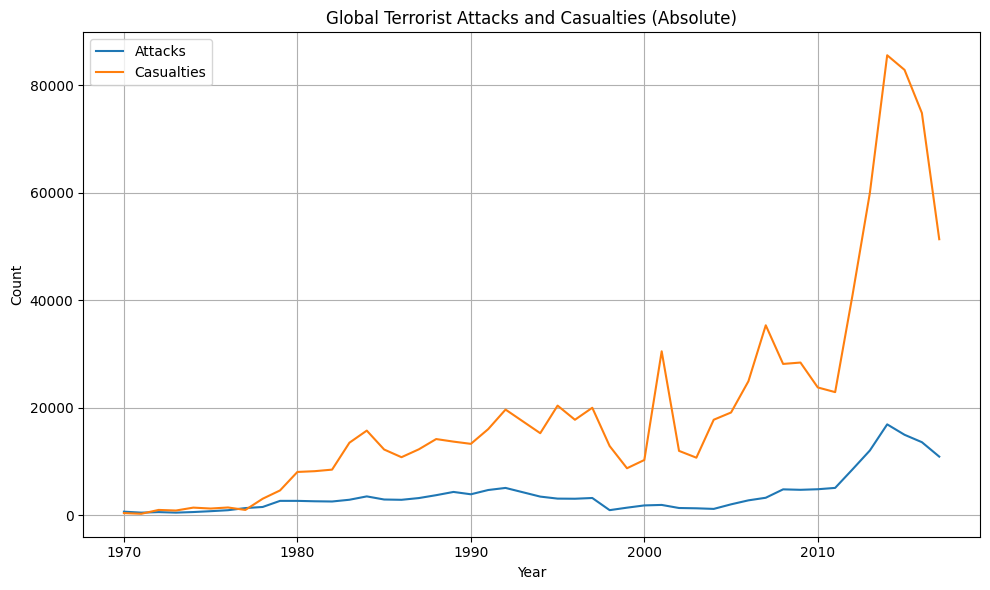

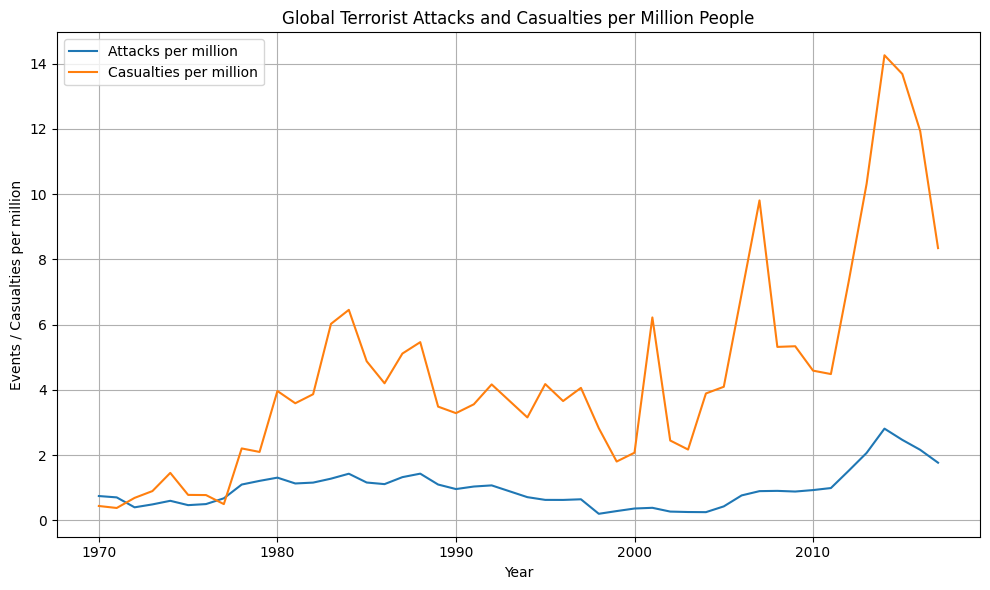


Regional time series (head):


,Region,Year,Total_Attacks,Total_Casualties,Region_Population,Pop_millions,Attacks_per_million,Casualties_per_million
0,Australasia & Oceania,1970,1,0.0,12507000.0,12.5070,0.079955,0.00000
1,Australasia & Oceania,1971,1,0.0,12937000.0,12.9370,0.077298,0.00000
2,Australasia & Oceania,1972,8,1.0,13177000.0,13.1770,0.607118,0.07589
3,Australasia & Oceania,1973,1,0.0,2961300.0,2.9613,0.337690,0.00000
4,Australasia & Oceania,1974,1,0.0,13723000.0,13.7230,0.072870,0.00000


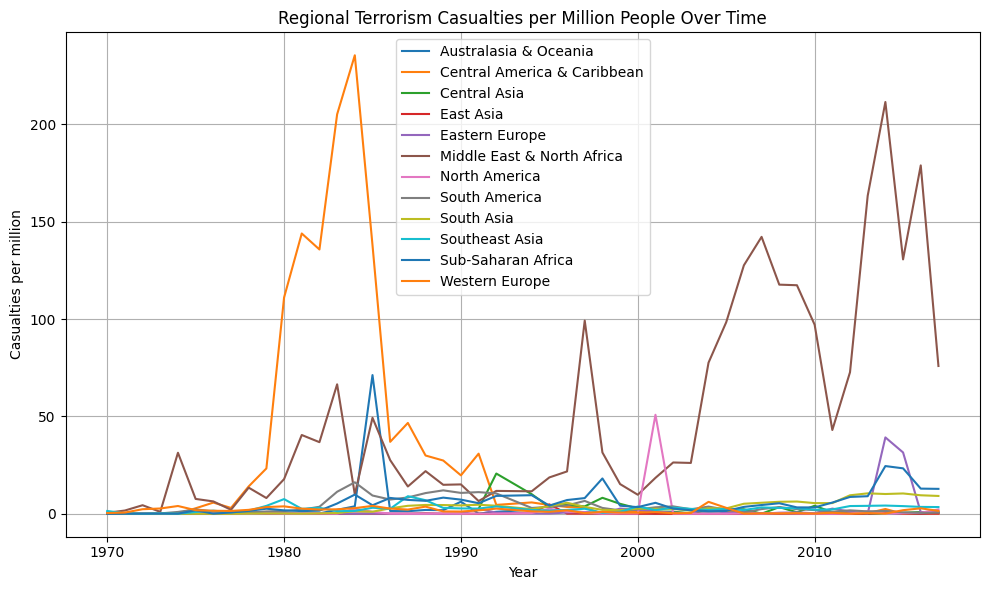

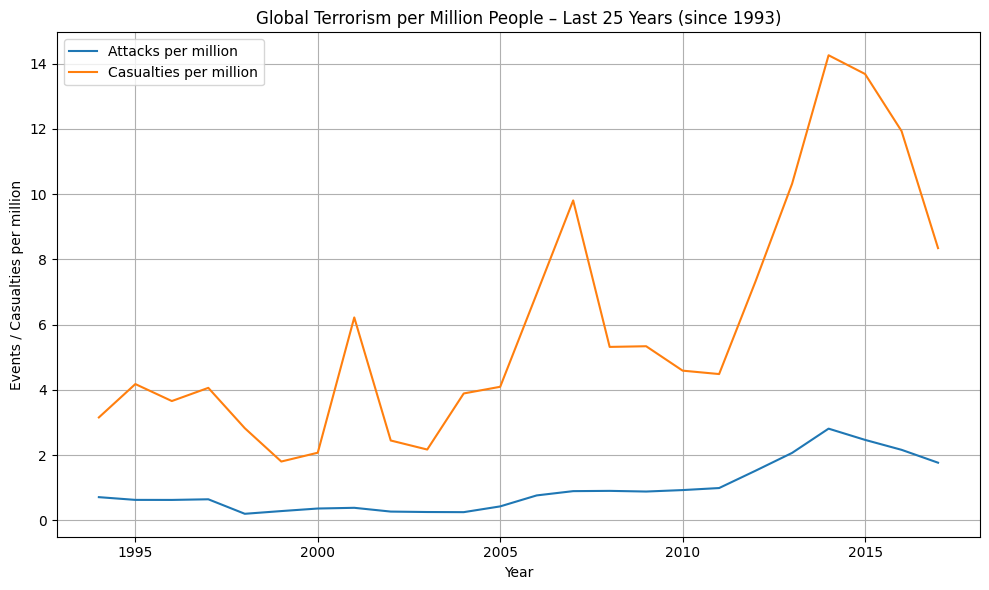


Summary (first & last 5 years, per-million casualties):


,Year,Casualties_per_million
0,1970,0.444315
1,1971,0.383315
2,1972,0.692689
3,1973,0.901597
4,1974,1.458508
42,2013,10.319861
43,2014,14.257320
44,2015,13.683220
45,2016,11.934036
46,2017,8.347034


In [ ]:
df_terr = terrorism_clean.copy()
df_wdi = wdi_clean.copy()

# Ensure we have a numeric 'Casualties' column
if "Casualties" not in df_terr.columns:
    killed_col = next((c for c in ["Killed", "nkill"] if c in df_terr.columns), None)
    wounded_col = next((c for c in ["Wounded", "nwound"] if c in df_terr.columns), None)
    if killed_col is None or wounded_col is None:
        raise ValueError("Cannot construct 'Casualties' – missing killed/wounded columns.")
    df_terr["Casualties"] = df_terr[killed_col].fillna(0) + df_terr[wounded_col].fillna(0)

# Aggregate by Country–Year (and keep Region for later)
group_cols = ["Country", "Year"]
if "Region" in df_terr.columns:
    group_cols.append("Region")

agg_dict = {
    "Attacks": ("Event_ID", "nunique") if "Event_ID" in df_terr.columns else ("Casualties", "count"),
    "Total_Casualties": ("Casualties", "sum"),
}

terror_cy = (
    df_terr
    .groupby(group_cols, as_index=False)
    .agg(**agg_dict)
)

print("Terrorism country–year shape:", terror_cy.shape)
display(terror_cy.head())


# 2.1.2 Merge Population to Build Per-Capita Measures


if "population" not in df_wdi.columns:
    raise ValueError("WDI dataset does not contain a 'population' column.")

wdi_pop = df_wdi[["Country", "Year", "population"]].copy()

terror_pop = terror_cy.merge(
    wdi_pop,
    on=["Country", "Year"],
    how="left"
)

# Per-million measures (where population is available)
terror_pop["population_millions"] = terror_pop["population"] / 1_000_000
terror_pop["Attacks_per_million"] = terror_pop["Attacks"] / terror_pop["population_millions"]
terror_pop["Casualties_per_million"] = terror_pop["Total_Casualties"] / terror_pop["population_millions"]

print("Rows with missing population:", terror_pop["population"].isna().sum())


# 2.1.3 Global Time Series (Absolute & Per Capita)


global_year = (
    terror_pop
    .groupby("Year", as_index=False)
    .agg(
        Total_Attacks=("Attacks", "sum"),
        Total_Casualties=("Total_Casualties", "sum"),
        # for per-capita, recompute using global population
        Global_Population=("population", "sum")
    )
)

global_year["Pop_millions"] = global_year["Global_Population"] / 1_000_000
global_year["Attacks_per_million"] = global_year["Total_Attacks"] / global_year["Pop_millions"]
global_year["Casualties_per_million"] = global_year["Total_Casualties"] / global_year["Pop_millions"]

print("\nGlobal time series (head):")
display(global_year.head())


# Plot: Global absolute counts
plt.figure(figsize=(10, 6))
plt.plot(global_year["Year"], global_year["Total_Attacks"], label="Attacks")
plt.plot(global_year["Year"], global_year["Total_Casualties"], label="Casualties")
plt.title("Global Terrorist Attacks and Casualties (Absolute)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  Plot: Global per-million rates
plt.figure(figsize=(10, 6))
plt.plot(global_year["Year"], global_year["Attacks_per_million"], label="Attacks per million")
plt.plot(global_year["Year"], global_year["Casualties_per_million"], label="Casualties per million")
plt.title("Global Terrorist Attacks and Casualties per Million People")
plt.xlabel("Year")
plt.ylabel("Events / Casualties per million")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 2.1.4 Regional Time Series (Per Capita)


if "Region" in terror_pop.columns:
    region_year = (
        terror_pop
        .dropna(subset=["population"])  # need population for per capita
        .groupby(["Region", "Year"], as_index=False)
        .agg(
            Total_Attacks=("Attacks", "sum"),
            Total_Casualties=("Total_Casualties", "sum"),
            Region_Population=("population", "sum")
        )
    )

    region_year["Pop_millions"] = region_year["Region_Population"] / 1_000_000
    region_year["Attacks_per_million"] = region_year["Total_Attacks"] / region_year["Pop_millions"]
    region_year["Casualties_per_million"] = region_year["Total_Casualties"] / region_year["Pop_millions"]

    print("\nRegional time series (head):")
    display(region_year.head())

    # Plot casualties per million by region
    plt.figure(figsize=(10, 6))
    for region in region_year["Region"].unique():
        sub = region_year[region_year["Region"] == region]
        plt.plot(sub["Year"], sub["Casualties_per_million"], label=region)

    plt.title("Regional Terrorism Casualties per Million People Over Time")
    plt.xlabel("Year")
    plt.ylabel("Casualties per million")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("No 'Region' column available – skipping regional per-capita trends.")



# 2.1.5 Focus on Last 25 Years

last_year = global_year["Year"].max()
cutoff = last_year - 24

global_last25 = global_year[global_year["Year"] >= cutoff].copy()

plt.figure(figsize=(10, 6))
plt.plot(global_last25["Year"], global_last25["Attacks_per_million"], label="Attacks per million")
plt.plot(global_last25["Year"], global_last25["Casualties_per_million"], label="Casualties per million")
plt.title(f"Global Terrorism per Million People – Last 25 Years (since {cutoff})")
plt.xlabel("Year")
plt.ylabel("Events / Casualties per million")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nSummary (first & last 5 years, per-million casualties):")
display(
    pd.concat(
        [global_year.head(5), global_year.tail(5)]
    )[["Year", "Casualties_per_million"]]
)


### 2.1. Data Interpretation

**Global Trends (Absolute Numbers)**

The global evolution of terrorist activity shows a clear upward trend in both the number of attacks and total casualties between 1970 and 2017, with several distinct phases:

- From 1970 to the late 1990s, terrorism remained relatively low and stable, with under 10,000 casualties per year globally.

- A moderate rise occurred around 2001-2003, corresponding to events surrounding 9/11 and the start of the Iraq War.

- A dramatic escalation followed between 2009 and 2014, when total casualties surged to over 80,000 deaths annually, largely driven by conflicts in Iraq, Syria, and Afghanistan during the rise of ISIS.

- After peaking around 2014, both attacks and casualties declined moderately, though remaining far above pre-2000 levels.

**Global Trends (Per Capita Perspective)**

When adjusted for global population growth (casualties per million people), the pattern shifts significantly:

- Despite the sharp increase in total casualties, per capita casualties remain low, never exceeding 15 per million globally.

- The long-term rise appears less dramatic in relative terms: while total casualties rose by a factor of 20 since 1970, the global population more than doubled, dampening the per-person risk.

- This challenges the perception that “the world is becoming more dangerous.” Instead, terrorism intensity has increased in localized regions, not uniformly worldwide.

**Regional Patterns**

The regional breakdown highlights strong geographic concentration:

- Middle East & North Africa (MENA) clearly dominates, with per-million casualty rates far exceeding all other regions — particularly between 2005 and 2016, aligning with conflicts in Iraq, Syria, Libya, and Yemen.

- South Asia (Afghanistan, Pakistan, India) also maintains persistently high terrorism intensity throughout the period.

- Sub-Saharan Africa shows a notable increase after 2005, corresponding to the expansion of groups such as Boko Haram and al-Shabaab.

- Other regions (Europe, Americas, East Asia, Oceania) remain relatively stable and low, with occasional spikes linked to isolated major incidents.

**Recent 25-Year Focus (1993-2017)**

- During the last quarter-century, global terrorism per capita fluctuated but followed a U-shaped pattern: a period of stability until 2005, followed by a surge peaking around 2014 (≈14.3 casualties per million).

- The subsequent decline after 2015 suggests partial stabilization, but rates remained around 8-10 casualties per million by 2017 — still well above pre-2000 levels.

## 2AQ2.2 - Concentration of Terrorism and Governance Quality

How concentrated are terrorist attacks and casualties in a small set of countries (per capita), and how do these high-risk countries differ in development (GDP, education, internet) and governance (CPI_2023) from low-risk countries?

The code below:

- Rebuilds a Country-Year terrorism + population dataset.

- Focuses on the last 25 years (you can change that).

- Aggregates to country level per-million risk.

- Measures concentration (top 10 countries, cumulative shares, Gini).

- Merges in development and governance variables and compares risk groups.

Terror_pop shape: (3762, 8)
Rows with missing population: 622
Using period 1993–2017, rows: 2196

Top 15 countries by casualties per million per year:


,Country,Total_Casualties,Casualties_per_million_per_year,Share_of_global_casualties,Cumulative_share
0,Iraq,212343.0,305.589261,0.320479,0.320479
1,St. Kitts And Nevis,9.0,211.515864,0.000014,0.320493
2,Afghanistan,82713.0,138.612238,0.124835,0.445327
3,Libya,5891.0,90.809097,0.008891,0.454218
4,St. Lucia,14.0,87.774295,0.000021,0.454239
5,Somalia,19077.0,75.044378,0.028792,0.483031
6,South Sudan,3957.0,60.009510,0.005972,0.489004
7,French Polynesia,13.0,56.168610,0.000020,0.489023
8,Israel,7117.0,42.227991,0.010741,0.499765
9,Central African Republic,2918.0,41.481944,0.004404,0.504169



What share of global casualties is accounted for by the top 10 countries?
Top 10 countries account for about 50.42% of global casualties in 1993–2017.

Gini coefficient of country-level casualties: 0.902 (0=equal, 1=fully concentrated)

Country profile (risk + development + governance) – head:


,Country,Total_Attacks,Total_Casualties,Pop_million_years,Casualties_per_million_per_year,Attacks_per_million_per_year,Share_of_global_casualties,Cumulative_share,GDP_current_US,government_expenditure_on_education%,individuals_using_internet%,CPI_2023,CPI_Rank
0,Iraq,24562,212343.0,694.864078,305.589261,35.347920,0.320479,0.320479,9.023016e+10,NaN,5.252617,23.0,154.0
1,St. Kitts And Nevis,2,9.0,0.042550,211.515864,47.003525,0.000014,0.320493,6.173156e+08,3.509066,34.852545,NaN,NaN
2,Afghanistan,12637,82713.0,596.722204,138.612238,21.177358,0.124835,0.445327,1.307730e+10,3.907689,3.546940,20.0,162.0
3,Libya,2240,5891.0,64.872355,90.809097,34.529346,0.008891,0.454218,4.785841e+10,2.264170,6.288411,18.0,170.0
4,St. Lucia,1,14.0,0.159500,87.774295,6.269592,0.000021,0.454239,1.225676e+09,4.307881,24.433194,NaN,NaN



Risk groups vs development & governance (quartiles of casualties per million per year):


/tmp/ipython-input-3806437884.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Risk_Quartile")


,Risk_Quartile,Countries,Mean_Casualties_per_million_per_year,Mean_GDP,Mean_Edu_Exp,Mean_Internet,Mean_CPI
0,Q1_Low,38,0.208157,4.262496e+11,4.819092,35.507493,58.138889
1,Q2,37,1.108778,2.307041e+11,4.687592,21.924629,41.837838
2,Q3,37,3.600217,5.645400e+11,4.050447,17.748490,40.783784
3,Q4_High,38,40.237574,4.355043e+10,3.613778,13.356078,31.971429


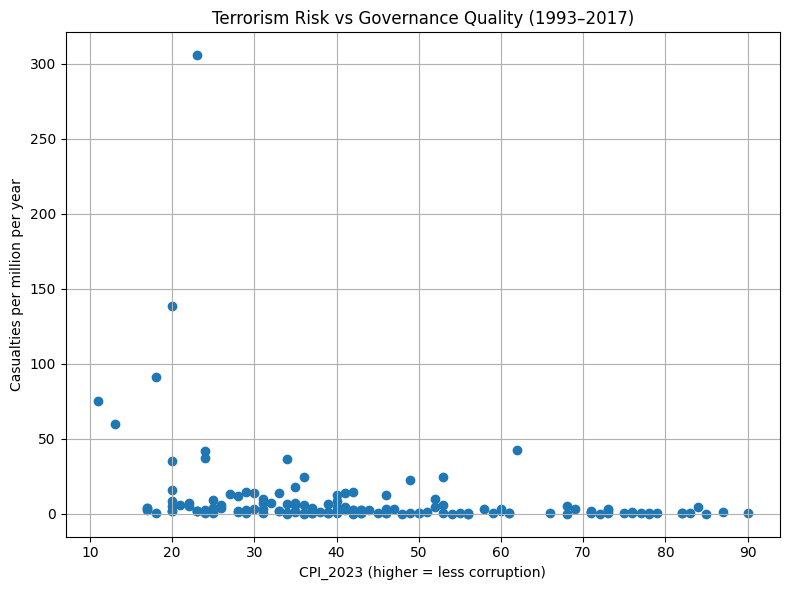

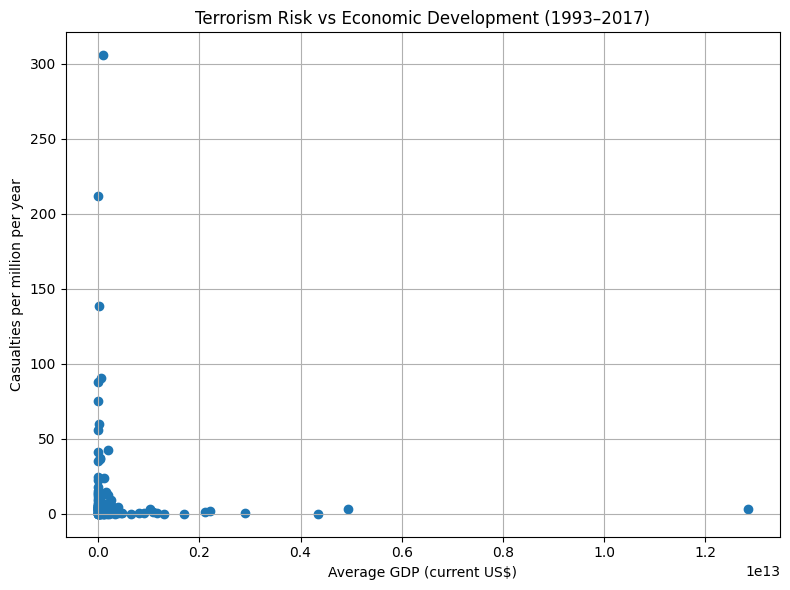

In [ ]:
# Helper: build Country–Year terrorism + population

def build_terror_pop_df(terror_df, wdi_df):
    df_terr = terror_df.copy()
    df_wdi = wdi_df.copy()

    # Ensure numeric casualties
    if "Casualties" not in df_terr.columns:
        killed_col = next((c for c in ["Killed", "nkill"] if c in df_terr.columns), None)
        wounded_col = next((c for c in ["Wounded", "nwound"] if c in df_terr.columns), None)
        if killed_col is None or wounded_col is None:
            raise ValueError("Cannot construct 'Casualties' – missing killed/wounded columns.")
        df_terr["Casualties"] = df_terr[killed_col].fillna(0) + df_terr[wounded_col].fillna(0)

    # Aggregate by Country–Year
    group_cols = ["Country", "Year"]
    agg_dict = {
        "Attacks": ("Event_ID", "nunique") if "Event_ID" in df_terr.columns else ("Casualties", "count"),
        "Total_Casualties": ("Casualties", "sum"),
    }

    terror_cy = (
        df_terr
        .groupby(group_cols, as_index=False)
        .agg(**agg_dict)
    )

    # Add population
    if "population" not in df_wdi.columns:
        raise ValueError("WDI dataset does not contain a 'population' column.")

    wdi_pop = df_wdi[["Country", "Year", "population"]].copy()

    terror_pop = terror_cy.merge(
        wdi_pop,
        on=["Country", "Year"],
        how="left"
    )

    terror_pop["population_millions"] = terror_pop["population"] / 1_000_000
    terror_pop["Attacks_per_million"] = terror_pop["Attacks"] / terror_pop["population_millions"]
    terror_pop["Casualties_per_million"] = terror_pop["Total_Casualties"] / terror_pop["population_millions"]

    return terror_pop


terror_pop = build_terror_pop_df(terrorism_clean, wdi_clean)
print("Terror_pop shape:", terror_pop.shape)
print("Rows with missing population:", terror_pop["population"].isna().sum())


# 2.2.1 Choose analysis period (e.g. last 25 years)

USE_LAST_N_YEARS = 25
max_year = terror_pop["Year"].max()
cutoff_year = max_year - USE_LAST_N_YEARS + 1

terror_pop_period = terror_pop[terror_pop["Year"] >= cutoff_year].copy()
print(f"Using period {cutoff_year}–{max_year}, rows:", terror_pop_period.shape[0])


# 2.2.2 Country-level risk (per million people)

# We approximate "person-years" as population_millions summed across years
country_risk = (
    terror_pop_period
    .dropna(subset=["population_millions"])
    .groupby("Country", as_index=False)
    .agg(
        Total_Attacks=("Attacks", "sum"),
        Total_Casualties=("Total_Casualties", "sum"),
        Pop_million_years=("population_millions", "sum")
    )
)

country_risk["Casualties_per_million_per_year"] = (
    country_risk["Total_Casualties"] / country_risk["Pop_million_years"]
)
country_risk["Attacks_per_million_per_year"] = (
    country_risk["Total_Attacks"] / country_risk["Pop_million_years"]
)

# Drop countries with missing or zero exposure
country_risk = country_risk.replace([np.inf, -np.inf], np.nan).dropna(
    subset=["Casualties_per_million_per_year"]
)

# Global totals + shares
total_cas = country_risk["Total_Casualties"].sum()
country_risk["Share_of_global_casualties"] = country_risk["Total_Casualties"] / total_cas

country_risk_sorted = country_risk.sort_values(
    "Casualties_per_million_per_year",
    ascending=False
).reset_index(drop=True)

country_risk_sorted["Cumulative_share"] = country_risk_sorted["Share_of_global_casualties"].cumsum()

print("\nTop 15 countries by casualties per million per year:")
display(
    country_risk_sorted.head(15)[
        ["Country", "Total_Casualties", "Casualties_per_million_per_year", "Share_of_global_casualties", "Cumulative_share"]
    ]
)

print("\nWhat share of global casualties is accounted for by the top 10 countries?")
top10_share = country_risk_sorted.head(10)["Share_of_global_casualties"].sum()
print(f"Top 10 countries account for about {top10_share:.2%} of global casualties in {cutoff_year}–{max_year}.")


# Simple Gini for concentration (using total casualties)
def gini(x):
    x = np.sort(np.array(x, dtype=float))
    n = len(x)
    if n == 0:
        return np.nan
    cumx = np.cumsum(x)
    return (2 * np.sum((np.arange(1, n + 1) * x)) / (n * np.sum(x))) - (n + 1) / n

gini_cas = gini(country_risk["Total_Casualties"])
print(f"\nGini coefficient of country-level casualties: {gini_cas:.3f} (0=equal, 1=fully concentrated)")

# 2.2.3 Merge with governance and development indicators

# Development: average over the same period from WDI
dev_cols = ["Country", "Year"]
for v in [
    "GDP_current_US",
    "government_expenditure_on_education%",
    "individuals_using_internet%"
]:
    if v in wdi_clean.columns:
        dev_cols.append(v)

wdi_dev = wdi_clean[wdi_dev_cols] if (wdi_dev_cols := dev_cols) else None

wdi_dev_period = wdi_dev[wdi_dev["Year"].between(cutoff_year, max_year)].copy()
dev_agg = (
    wdi_dev_period
    .groupby("Country", as_index=False)
    .agg({
        "GDP_current_US": "mean" if "GDP_current_US" in wdi_dev_period.columns else "mean",
        "government_expenditure_on_education%": "mean" if "government_expenditure_on_education%" in wdi_dev_period.columns else "mean",
        "individuals_using_internet%": "mean" if "individuals_using_internet%" in wdi_dev_period.columns else "mean",
    })
)

# Governance: CPI_2023 (one observation per country)
gov_cols = ["Country"]
for v in ["CPI_2023", "CPI_Rank"]:
    if v in governance_clean.columns:
        gov_cols.append(v)

gov_subset = governance_clean[gov_cols].drop_duplicates(subset=["Country"])

# Merge everything
country_profile = (
    country_risk_sorted
    .merge(dev_agg, on="Country", how="left")
    .merge(gov_subset, on="Country", how="left")
)

print("\nCountry profile (risk + development + governance) – head:")
display(country_profile.head())


# 2.2.4 Compare high-risk vs low-risk countries

# Create quartiles of risk based on casualties per million per year
country_profile["Risk_Quartile"] = pd.qcut(
    country_profile["Casualties_per_million_per_year"],
    q=4,
    labels=["Q1_Low", "Q2", "Q3", "Q4_High"]
)

risk_summary = (
    country_profile
    .groupby("Risk_Quartile")
    .agg(
        Countries=("Country", "nunique"),
        Mean_Casualties_per_million_per_year=("Casualties_per_million_per_year", "mean"),
        Mean_GDP=("GDP_current_US", "mean") if "GDP_current_US" in country_profile.columns else ("Casualties_per_million_per_year", "mean"),
        Mean_Edu_Exp=("government_expenditure_on_education%", "mean") if "government_expenditure_on_education%" in country_profile.columns else ("Casualties_per_million_per_year", "mean"),
        Mean_Internet=("individuals_using_internet%", "mean") if "individuals_using_internet%" in country_profile.columns else ("Casualties_per_million_per_year", "mean"),
        Mean_CPI=("CPI_2023", "mean") if "CPI_2023" in country_profile.columns else ("Casualties_per_million_per_year", "mean"),
    )
    .reset_index()
)

print("\nRisk groups vs development & governance (quartiles of casualties per million per year):")
display(risk_summary)


# 2.2.5 Optional scatter plots for visual comparison

# Scatter: CPI vs casualties per million per year
if "CPI_2023" in country_profile.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(
        country_profile["CPI_2023"],
        country_profile["Casualties_per_million_per_year"]
    )
    plt.xlabel("CPI_2023 (higher = less corruption)")
    plt.ylabel("Casualties per million per year")
    plt.title(f"Terrorism Risk vs Governance Quality ({cutoff_year}–{max_year})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Scatter: GDP vs casualties per million per year
if "GDP_current_US" in country_profile.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(
        country_profile["GDP_current_US"],
        country_profile["Casualties_per_million_per_year"]
    )
    plt.xlabel("Average GDP (current US$)")
    plt.ylabel("Casualties per million per year")
    plt.title(f"Terrorism Risk vs Economic Development ({cutoff_year}–{max_year})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### 2.2. Data Interpretation

**Global Concentration of Terrorism**

- Terrorism is extremely concentrated in a few countries.
The top 10 countries (e.g., Iraq, Afghanistan, Libya, Somalia, South Sudan) accounted for about 50.4% of all global casualties between 1993 and 2017.

- The Gini coefficient of 0.902 confirms a very high concentration — almost all global terrorism fatalities are confined to a handful of countries.
(In inequality terms, this is comparable to extreme income inequality — suggesting terrorism is not globally widespread.)

**High-Risk Countries**

- Iraq and Afghanistan stand out sharply, with casualties per million per year of 305.6 and 138.6, respectively.

- Other countries in the top 15 — including Libya, Somalia, South Sudan, and Algeria — are typically conflict zones or post-conflict states, often characterized by fragile governance, civil unrest, or international military interventions.

- Interestingly, some small states (e.g., St. Kitts and Nevis or St. Lucia) appear high in per-million terms due to tiny populations, so their inclusion reflects statistical sensitivity rather than persistent terrorism.

**Governance and Development Correlates**

- The scatterplot between CPI_2023 (governance quality) and casualties per million per year shows a clear negative relationship:

- Countries with lower CPI (higher corruption) tend to experience much higher terrorism risk. High-CPI countries (e.g., those scoring above 60–70, such as Western democracies) cluster near zero casualties.

- Similarly, the scatterplot between GDP (economic development) and terrorism shows that most terrorism occurs in low- or middle-income countries, while richer countries have minimal risk.
A few outliers with very large GDPs but low terrorism risk (e.g., the US, Japan, Germany) demonstrate that wealth alone does not increase exposure.

**Quartile Comparison of Country Risk**

| Risk Group | Avg. Casualties per Million / Year | Avg. CPI (Governance) | Avg. GDP (US$) | Avg. Education Exp. % | Avg. Internet % |
| ---------- | ---------------------------------- | --------------------- | -------------- | --------------------- | --------------- |
| Q1 (Low)   | 0.2                                | **58.1**              | High           | 4.82                  | 35.5            |
| Q2         | 1.1                                | 41.8                  | Moderate       | 4.69                  | 21.9            |
| Q3         | 3.6                                | 40.8                  | Moderate       | 4.05                  | 17.7            |
| Q4 (High)  | **40.2**                           | **32.0**              | Low            | **3.6**               | **13.4**        |

- Governance quality (CPI) decreases steadily as terrorism risk rises — from 58.1 in low-risk countries to 32.0 in high-risk ones.

- Economic development also declines with higher terrorism risk.

- Education expenditure and internet penetration are substantially lower among high-risk countries, suggesting less human capital and connectivity.

- Overall, countries most exposed to terrorism combine weak governance, lower economic capacity, limited education investment, and low technological access.

**Interpretation**

- The data strongly support the hypothesis that terrorism is concentrated in fragile states with weak governance and low socioeconomic development.

-  Wealthier, better-governed, and more digitally connected countries remain largely insulated from sustained terrorism.

- Terrorism thus appears to be a byproduct of institutional weakness, political instability, and slow development rather than a global threat evenly distributed across nations.

## AQ2.3 - Improvements in Governance and Development vs Terrorism
W are going to look whether **improvements in governance and development are associated with lower terrorism intensity over time**, using a country-year panel:

- Terrorism intensity = casualties per million people

- Governance proxies (from WDI):`control_of_corruption_estimate`, `rule_of_law_estimate`,
`political_stability_estimate`, `voice_and_accountability_estimate`

- Development: `GDP_current_US` (we'll use log_GDP)

- Governance level (cross-section):  `CPI_2023` as a control



terror_pop shape: (3762, 8)
Panel after merging governance: (1360, 13)


,Country,Year,Attacks,Total_Casualties,population,population_millions,Attacks_per_million,Casualties_per_million,control_of_corruption_estimate,rule_of_law_estimate,political_stability_estimate,voice_and_accountability_estimate,GDP_current_US
10,Afghanistan,1996,4,61.0,17106595.0,17.106595,0.233828,3.565876,-1.291705,-1.788075,-2.417310,-1.908540,NaN
12,Afghanistan,1998,1,38.0,18493132.0,18.493132,0.054074,2.054817,-1.176012,-1.734887,-2.427355,-2.039301,NaN
14,Afghanistan,2000,14,49.0,19542982.0,19.542982,0.716370,2.507294,-1.271724,-1.780661,-2.438969,-2.031417,NaN
16,Afghanistan,2002,38,371.0,21000256.0,21.000256,1.809502,17.666451,-1.251137,-1.673473,-2.035034,-1.433421,3.825701e+09
17,Afghanistan,2003,100,349.0,22645130.0,22.645130,4.415961,15.411702,-1.344180,-1.558294,-2.198372,-1.177571,4.520947e+09


Early period: 1996–2006, Late period: 2007–2017

Change in governance vs change in terrorism (head):


,Country,Cas_early,Corruption_early,Cas_late,Corruption_late,ΔCas_per_million,ΔCorruption
0,Afghanistan,20.115817,-1.322369,221.854620,-1.522821,201.738803,-0.200452
1,Albania,3.871735,-0.898820,0.173064,-0.563186,-3.698671,0.335634
2,Algeria,28.259578,-0.730668,7.107634,-0.589397,-21.151944,0.141271
3,Angola,10.110530,-1.175290,3.599193,-1.414478,-6.511337,-0.239188
4,Argentina,0.122447,-0.319677,0.010364,-0.420312,-0.112084,-0.100634


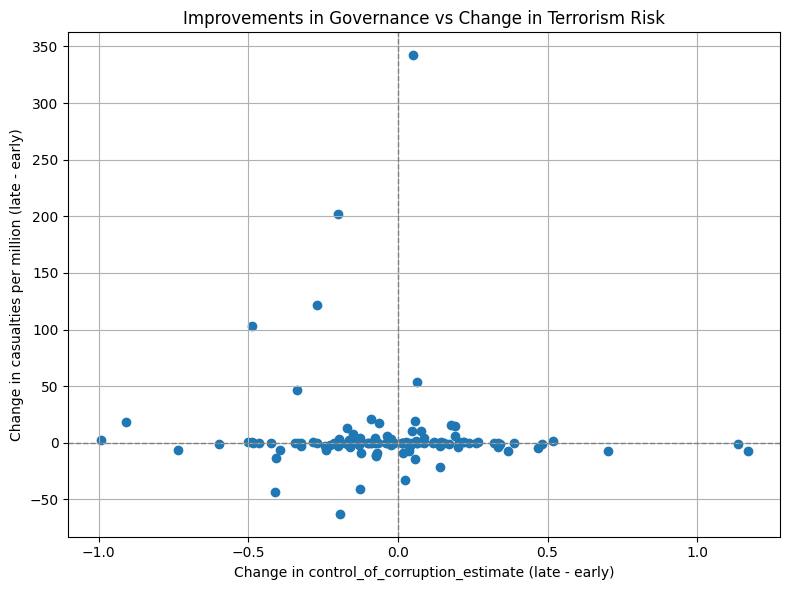


=== Country Fixed-Effects Regression ===
Using X vars: ['control_of_corruption_estimate', 'rule_of_law_estimate', 'political_stability_estimate', 'voice_and_accountability_estimate', 'log_GDP']
Using Y var: Casualties_per_million
                                      OLS Regression Results                                      
Dep. Variable:     Casualties_per_million_within   R-squared (uncentered):                   0.092
Model:                                       OLS   Adj. R-squared (uncentered):              0.089
Method:                            Least Squares   F-statistic:                              26.91
Date:                           Mon, 24 Nov 2025   Prob (F-statistic):                    5.48e-26
Time:                                   15:38:17   Log-Likelihood:                         -6705.2
No. Observations:                           1332   AIC:                                  1.342e+04
Df Residuals:                               1327   BIC:                     

,Coef,Sign
control_of_corruption_estimate_within,4.559245,1.0
rule_of_law_estimate_within,-17.760833,-1.0
political_stability_estimate_within,-24.325059,-1.0
voice_and_accountability_estimate_within,33.553174,1.0
log_GDP_within,10.064479,1.0


In [ ]:
# 2.3.1 Build terrorism + population panel


def build_terror_pop_df(terror_df, wdi_df):
    df_terr = terror_df.copy()
    df_wdi = wdi_df.copy()

    # Ensure numeric casualties
    if "Casualties" not in df_terr.columns:
        killed_col = next((c for c in ["Killed", "nkill"] if c in df_terr.columns), None)
        wounded_col = next((c for c in ["Wounded", "nwound"] if c in df_terr.columns), None)
        if killed_col is None or wounded_col is None:
            raise ValueError("Cannot construct 'Casualties' – missing killed/wounded columns.")
        df_terr["Casualties"] = df_terr[killed_col].fillna(0) + df_terr[wounded_col].fillna(0)

    # Aggregate by Country–Year
    terr_cy = (
        df_terr
        .groupby(["Country", "Year"], as_index=False)
        .agg(
            Attacks=("Event_ID", "nunique") if "Event_ID" in df_terr.columns else ("Casualties", "count"),
            Total_Casualties=("Casualties", "sum"),
        )
    )

    # Add population from WDI
    if "population" not in df_wdi.columns:
        raise ValueError("WDI dataset does not contain a 'population' column.")

    wdi_pop = df_wdi[["Country", "Year", "population"]].copy()

    terr_pop = terr_cy.merge(
        wdi_pop,
        on=["Country", "Year"],
        how="left"
    )

    terr_pop["population_millions"] = terr_pop["population"] / 1_000_000
    terr_pop["Casualties_per_million"] = terr_pop["Total_Casualties"] / terr_pop["population_millions"]

    return terr_pop


try:
    terror_pop
except NameError:
    terror_pop = build_terror_pop_df(terrorism_clean, wdi_clean)

print("terror_pop shape:", terror_pop.shape)


# 2.3.2 Bring in time-varying governance & development indicators (WDI)

# Governance proxies that exist in WDI
gov_time_candidates = [
    "control_of_corruption_estimate",
    "rule_of_law_estimate",
    "political_stability_estimate",
    "voice_and_accountability_estimate",
]

gov_time_cols = ["Country", "Year"] + [c for c in gov_time_candidates if c in wdi_clean.columns]

wdi_gov = wdi_clean[gov_time_cols].copy()

# Add GDP for development control
if "GDP_current_US" in wdi_clean.columns:
    wdi_gov = wdi_gov.merge(
        wdi_clean[["Country", "Year", "GDP_current_US"]],
        on=["Country", "Year"],
        how="left"
    )

# Merge with terrorism panel
panel = terror_pop.merge(wdi_gov, on=["Country", "Year"], how="left")

# Restrict to years where governance proxies exist (typically from 1996 onward)
non_null_gov_cols = [c for c in gov_time_candidates if c in panel.columns]
panel = panel.dropna(subset=non_null_gov_cols, how="all").copy()

# Also drop rows with missing casualties_per_million or population
panel = panel.dropna(subset=["Casualties_per_million", "population_millions"])

print("Panel after merging governance:", panel.shape)
display(panel.head())


# 2.3.3 Descriptive: changes in governance vs changes in terrorism

# For each country, compare early vs late period averages
early_year = panel["Year"].min()
late_year = panel["Year"].max()
mid_year = (early_year + late_year) // 2

print(f"Early period: {early_year}–{mid_year}, Late period: {mid_year+1}–{late_year}")

def avg_by_period(df, start, end, label):
    tmp = (
        df[df["Year"].between(start, end)]
        .groupby("Country", as_index=False)
        .agg(
            Cas_per_million=( "Casualties_per_million", "mean"),
            Gov_corruption=("control_of_corruption_estimate", "mean") if "control_of_corruption_estimate" in df.columns else ("Year", "mean"),
        )
    )
    tmp = tmp.rename(
        columns={
            "Cas_per_million": f"Cas_{label}",
            "Gov_corruption": f"Corruption_{label}",
        }
    )
    return tmp

early = avg_by_period(panel, early_year, mid_year, "early")
late  = avg_by_period(panel, mid_year + 1, late_year, "late")

change_df = early.merge(late, on="Country", how="inner")

change_df["ΔCas_per_million"] = change_df["Cas_late"] - change_df["Cas_early"]
change_df["ΔCorruption"] = change_df["Corruption_late"] - change_df["Corruption_early"]  # higher = less corruption

print("\nChange in governance vs change in terrorism (head):")
display(change_df.head())

# Scatter: improvement in governance vs change in terrorism risk
plt.figure(figsize=(8, 6))
plt.scatter(change_df["ΔCorruption"], change_df["ΔCas_per_million"])
plt.axhline(0, color="grey", linestyle="--", linewidth=1)
plt.axvline(0, color="grey", linestyle="--", linewidth=1)
plt.xlabel("Change in control_of_corruption_estimate (late - early)")
plt.ylabel("Change in casualties per million (late - early)")
plt.title("Improvements in Governance vs Change in Terrorism Risk")
plt.grid(True)
plt.tight_layout()
plt.show()


# 2.3.4 Country fixed-effects regression (within estimator)


print("\n=== Country Fixed-Effects Regression ===")

reg_cols = ["Country", "Year", "Casualties_per_million"]

# Governance variables we actually have in the panel
gov_vars = [c for c in gov_time_candidates if c in panel.columns]
reg_cols += gov_vars

# Add GDP (development)
if "GDP_current_US" in panel.columns:
    reg_cols.append("GDP_current_US")

reg_df = panel[reg_cols].dropna().copy()

# Log GDP to reduce skew
if "GDP_current_US" in reg_df.columns:
    reg_df["log_GDP"] = np.log1p(reg_df["GDP_current_US"])
    x_vars = gov_vars + ["log_GDP"]
else:
    x_vars = gov_vars

y_var = "Casualties_per_million"

print("Using X vars:", x_vars)
print("Using Y var:", y_var)

# Within transformation: subtract country means (country fixed effects)
for col in [y_var] + x_vars:
    reg_df[col + "_within"] = reg_df[col] - reg_df.groupby("Country")[col].transform("mean")

Y = reg_df[y_var + "_within"]
X = reg_df[[c + "_within" for c in x_vars]]

# No intercept after demeaning
model_fe = sm.OLS(Y, X).fit()
print(model_fe.summary())


# 2.3.5 Simple interpretation helper (signs of coefficients)


coef_summary = model_fe.params.to_frame("Coef").copy()
coef_summary["Sign"] = np.sign(coef_summary["Coef"])
coef_summary


### 2.3. Data Interpretation

**Descriptive Patterns**

- The change analysis (scatterplot of change in corruption control vs. change in terrorism) shows no strong linear relationship.
However, there is a weak tendency for countries that improved governance (moved right on the x-axis) to experience declines or stability in terrorism intensity (closer to zero or negative on the y-axis).

- Most countries cluster around small governance and terrorism changes, indicating stability in both governance and terrorism over time.
A few extreme outliers (e.g., Iraq, Afghanistan, Nigeria) drive global variation, as seen in previous analyses.

**Regression Results (Country Fixed-Effects Model)**

*Dependent variable*: casualties per million people (within-country changes)
*Independent variables*: time-varying governance proxies + log GDP

| Variable                   | Coefficient | Significance                     | Interpretation                                                                                                                                                     |
| -------------------------- | ----------- | -------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Control of corruption**  | +4.56       | Not significant (p=0.48)         | No robust effect; within-country variation in corruption control doesn’t consistently affect terrorism intensity.                                                  |
| **Rule of law**            | **−17.8**   | **Significant (p=0.02)**         | Stronger rule of law correlates with fewer terrorism casualties within countries over time.                                                                        |
| **Political stability**    | **−24.4**   | **Highly significant (p<0.001)** | The most powerful predictor: improvements in political stability lead to substantial reductions in terrorism.                                                      |
| **Voice & accountability** | +33.6       | **Significant (p=0.001)**        | Countries that become more open or democratic may see short-term increases in terrorism (possibly due to greater freedom of expression or political contestation). |
| **log GDP**                | **+10.1**   | **Significant (p=0.05)**         | Economic growth alone does not guarantee safety; higher GDP may coincide with more visible targets or higher reporting capacity.                                   |

**Interpretation**

- Governance quality matters, but not all aspects have the same effect:

- Political stability and rule of law are the most effective shields against terrorism.

- Voice and accountability—while essential for democracy—can sometimes increase short-term instability as societies open up politically.

- Corruption control, although theoretically important, shows no statistically robust link once country fixed effects are accounted for.

- Economic development (GDP) alone does not reduce terrorism; governance and institutional quality are more decisive.

## AQ2.4 - Country Clustering (Risk Profiles)

- build a country-level terrorism risk metric (casualties per million per year, last 25 years),

- merge development and governance indicators,

- standardize features and run K-Means clustering (K=4),

- give you cluster profiles and a scatter plot to interpret the groups.

terror_pop shape: (3762, 8)
country_risk shape: (150, 6)


,Country,Total_Attacks,Total_Casualties,Pop_million_years,Casualties_per_million_per_year,Attacks_per_million_per_year
0,Afghanistan,12637,82713.0,596.722204,138.612238,21.177358
1,Albania,74,167.0,42.291950,3.948742,1.749742
2,Algeria,2492,19586.0,810.894312,24.153579,3.073150
3,Angola,163,3319.0,243.953418,13.605056,0.668160
4,Argentina,85,376.0,672.229460,0.559333,0.126445


country_profile shape: (150, 12)


,Country,Total_Attacks,Total_Casualties,Pop_million_years,Casualties_per_million_per_year,Attacks_per_million_per_year,GDP_current_US,government_expenditure_on_education%,individuals_using_internet%,gini_index,CPI_2023,CPI_Rank
0,Afghanistan,12637,82713.0,596.722204,138.612238,21.177358,1.307730e+10,3.907689,3.546940,NaN,20.0,162.0
1,Albania,74,167.0,42.291950,3.948742,1.749742,7.727307e+09,3.400665,21.064427,31.388889,37.0,98.0
2,Algeria,2492,19586.0,810.894312,24.153579,3.073150,1.119625e+11,6.899252,11.212436,31.450000,36.0,104.0
3,Angola,163,3319.0,243.953418,13.605056,0.668160,4.960034e+10,2.873944,5.231487,47.350000,33.0,121.0
4,Argentina,85,376.0,672.229460,0.559333,0.126445,3.451978e+11,4.704901,27.070522,46.675000,37.0,98.0


Data used for clustering: (150, 8)


,Country,Casualties_per_million_per_year,Attacks_per_million_per_year,GDP_current_US,government_expenditure_on_education%,individuals_using_internet%,gini_index,CPI_2023
0,Afghanistan,138.612238,21.177358,1.307730e+10,3.907689,3.546940,38.433333,20.0
1,Albania,3.948742,1.749742,7.727307e+09,3.400665,21.064427,31.388889,37.0
2,Algeria,24.153579,3.073150,1.119625e+11,6.899252,11.212436,31.450000,36.0
3,Angola,13.605056,0.668160,4.960034e+10,2.873944,5.231487,47.350000,33.0
4,Argentina,0.559333,0.126445,3.451978e+11,4.704901,27.070522,46.675000,37.0



Cluster counts:
Cluster
0    48
1     1
2    97
3     4
Name: count, dtype: int64

Cluster profiles:


,Cluster,Countries,Mean_Casualties_per_million_per_year,Mean_Attacks_per_million_per_year,Mean_GDP,Mean_Edu_Exp,Mean_Internet,Mean_Gini,Mean_CPI
0,0,48,2.423825,1.495644,4.727048e+11,5.277029,44.227495,32.674558,63.680851
1,1,1,3.189424,0.105372,1.283271e+13,6.097829,54.501688,40.616000,69.000000
2,2,97,8.712485,1.836543,1.196094e+11,3.857033,11.312981,42.774751,33.468085
3,3,4,186.631615,34.514538,3.794580e+10,3.226975,12.485128,29.050000,20.333333



Example countries per cluster:
Cluster 0: Australia, Austria, Belarus, Belgium, Bhutan, Canada, Croatia, Cuba, Cyprus, Denmark...
Cluster 1: United States
Cluster 2: Albania, Algeria, Angola, Argentina, Armenia, Azerbaijan, Bahrain, Bangladesh, Belize, Benin...
Cluster 3: Afghanistan, Iraq, Libya, St. Kitts And Nevis


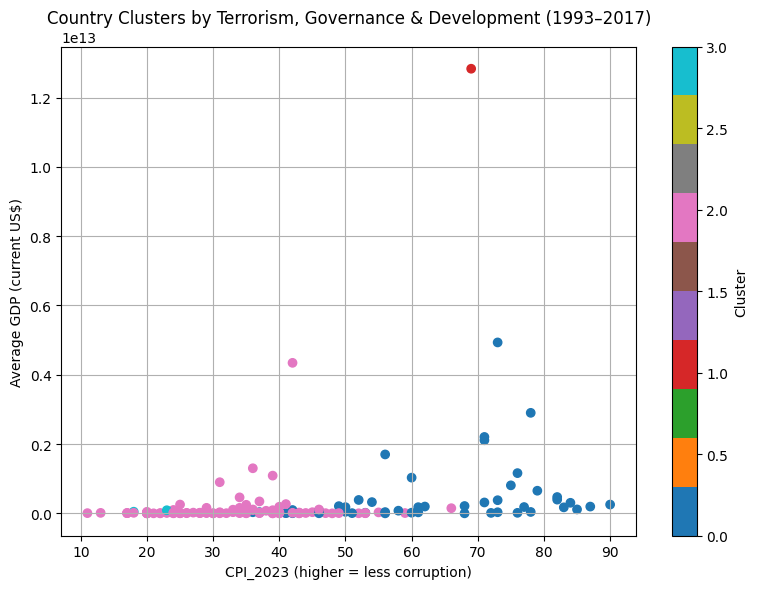

In [ ]:
# 2.4.1 Build terrorism + population table

def build_terror_pop_df(terror_df, wdi_df):
    df_terr = terror_df.copy()
    df_wdi = wdi_df.copy()

    # Ensure numeric casualties
    if "Casualties" not in df_terr.columns:
        killed_col = next((c for c in ["Killed", "nkill"] if c in df_terr.columns), None)
        wounded_col = next((c for c in ["Wounded", "nwound"] if c in df_terr.columns), None)
        if killed_col is None or wounded_col is None:
            raise ValueError("Cannot construct 'Casualties' – missing killed/wounded columns.")
        df_terr["Casualties"] = df_terr[killed_col].fillna(0) + df_terr[wounded_col].fillna(0)

    # Country–year aggregation
    terr_cy = (
        df_terr
        .groupby(["Country", "Year"], as_index=False)
        .agg(
            Attacks=("Event_ID", "nunique") if "Event_ID" in df_terr.columns else ("Casualties", "count"),
            Total_Casualties=("Casualties", "sum"),
        )
    )

    # Add population
    if "population" not in df_wdi.columns:
        raise ValueError("WDI dataset does not contain a 'population' column.")

    wdi_pop = df_wdi[["Country", "Year", "population"]].copy()

    terr_pop = terr_cy.merge(
        wdi_pop,
        on=["Country", "Year"],
        how="left"
    )

    terr_pop["population_millions"] = terr_pop["population"] / 1_000_000
    terr_pop["Casualties_per_million"] = terr_pop["Total_Casualties"] / terr_pop["population_millions"]

    return terr_pop


try:
    terror_pop
except NameError:
    terror_pop = build_terror_pop_df(terrorism_clean, wdi_clean)

print("terror_pop shape:", terror_pop.shape)


# 2.4.2 Country-level terrorism risk (last 25 years)

USE_LAST_N_YEARS = 25
max_year = terror_pop["Year"].max()
cutoff_year = max_year - USE_LAST_N_YEARS + 1

terror_pop_period = terror_pop[terror_pop["Year"] >= cutoff_year].copy()

country_risk = (
    terror_pop_period
    .dropna(subset=["population_millions"])
    .groupby("Country", as_index=False)
    .agg(
        Total_Attacks=("Attacks", "sum"),
        Total_Casualties=("Total_Casualties", "sum"),
        Pop_million_years=("population_millions", "sum")
    )
)

country_risk["Casualties_per_million_per_year"] = (
    country_risk["Total_Casualties"] / country_risk["Pop_million_years"]
)
country_risk["Attacks_per_million_per_year"] = (
    country_risk["Total_Attacks"] / country_risk["Pop_million_years"]
)

country_risk = country_risk.replace([np.inf, -np.inf], np.nan).dropna(
    subset=["Casualties_per_million_per_year"]
)

print("country_risk shape:", country_risk.shape)
display(country_risk.head())


# 2.4.3 Add development & governance indicators

# Development variables from WDI (averaged over the same period)
desired_dev = [
    "GDP_current_US",
    "government_expenditure_on_education%",
    "individuals_using_internet%",
    "gini_index",
]

available_dev = [c for c in desired_dev if c in wdi_clean.columns]

dev_cols = ["Country", "Year"] + available_dev
wdi_dev_period = wdi_clean[dev_cols].copy()
wdi_dev_period = wdi_dev_period[wdi_dev_period["Year"].between(cutoff_year, max_year)]

if available_dev:
    dev_agg = (
        wdi_dev_period
        .groupby("Country", as_index=False)[available_dev]
        .mean()
    )
else:
    # If no dev columns exist, just create a Country-only df
    dev_agg = country_risk[["Country"]].copy()

# Governance (CPI_2023 etc.)
gov_cols = ["Country"]
for v in ["CPI_2023", "CPI_Rank"]:
    if v in governance_clean.columns:
        gov_cols.append(v)

gov_subset = governance_clean[gov_cols].drop_duplicates(subset=["Country"])

# Merge into a unified country profile
country_profile = (
    country_risk
    .merge(dev_agg, on="Country", how="left")
    .merge(gov_subset, on="Country", how="left")
)

print("country_profile shape:", country_profile.shape)
display(country_profile.head())


# 2.4.4 Prepare data for clustering

feature_cols = [
    "Casualties_per_million_per_year",
    "Attacks_per_million_per_year",
]

for v in ["GDP_current_US",
          "government_expenditure_on_education%",
          "individuals_using_internet%",
          "gini_index",
          "CPI_2023"]:
    if v in country_profile.columns:
        feature_cols.append(v)

cluster_df = country_profile[["Country"] + feature_cols].copy()

# Drop rows with missing core risk variable
cluster_df = cluster_df.dropna(subset=["Casualties_per_million_per_year"])

# Fill remaining missing numeric values with median per column
for col in feature_cols:
    median_val = cluster_df[col].median(skipna=True)
    cluster_df[col] = cluster_df[col].fillna(median_val)

print("Data used for clustering:", cluster_df.shape)
display(cluster_df.head())


# 2.4.5 Standardize features and run KMeans

X = cluster_df[feature_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

K = 4  # number of clusters
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

cluster_df["Cluster"] = cluster_labels

# Attach clusters back to full country profile
country_profile = country_profile.merge(
    cluster_df[["Country", "Cluster"]],
    on="Country",
    how="left"
)

print("\nCluster counts:")
print(country_profile["Cluster"].value_counts().sort_index())


# 2.4.6 Cluster profiles

cluster_profile = (
    country_profile
    .groupby("Cluster")
    .agg(
        Countries=("Country", "nunique"),
        Mean_Casualties_per_million_per_year=("Casualties_per_million_per_year", "mean"),
        Mean_Attacks_per_million_per_year=("Attacks_per_million_per_year", "mean"),
        Mean_GDP=("GDP_current_US", "mean") if "GDP_current_US" in country_profile.columns else ("Casualties_per_million_per_year", "mean"),
        Mean_Edu_Exp=("government_expenditure_on_education%", "mean") if "government_expenditure_on_education%" in country_profile.columns else ("Casualties_per_million_per_year", "mean"),
        Mean_Internet=("individuals_using_internet%", "mean") if "individuals_using_internet%" in country_profile.columns else ("Casualties_per_million_per_year", "mean"),
        Mean_Gini=("gini_index", "mean") if "gini_index" in country_profile.columns else ("Casualties_per_million_per_year", "mean"),
        Mean_CPI=("CPI_2023", "mean") if "CPI_2023" in country_profile.columns else ("Casualties_per_million_per_year", "mean"),
    )
    .reset_index()
)

print("\nCluster profiles:")
display(cluster_profile)

print("\nExample countries per cluster:")
for c in sorted(country_profile["Cluster"].dropna().unique()):
    names = country_profile[country_profile["Cluster"] == c]["Country"].head(10).tolist()
    print(f"Cluster {c}: {', '.join(names)}{'...' if len(names) == 10 else ''}")


# 2.4.7 Visualisation: CPI vs GDP, coloured by cluster

if ("CPI_2023" in country_profile.columns) and ("GDP_current_US" in country_profile.columns):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        country_profile["CPI_2023"],
        country_profile["GDP_current_US"],
        c=country_profile["Cluster"],
        cmap="tab10"
    )
    plt.xlabel("CPI_2023 (higher = less corruption)")
    plt.ylabel("Average GDP (current US$)")
    plt.title(f"Country Clusters by Terrorism, Governance & Development ({cutoff_year}–{max_year})")
    plt.colorbar(scatter, label="Cluster")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### 2.4. Data Interpretation

| Cluster | Countries | Avg Casualties per Million | Avg Attacks per Million | Governance & Development Profile                                                                                                                              |
| ------- | --------- | -------------------------- | ----------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **0**   | 48        | **Low** (≈ 2.4)            | **Low**                 | High GDP (~$472B), high internet use, high CPI (low corruption), moderate inequality → **Stable, high-income democracies**                                    |
| **1**   | 1 (USA)   | **Low** (≈ 3.2)            | **Very Low**            | Exceptionally high GDP (~$12.8T), strong governance, very high education spending → **Unique outlier: wealthy superpower with global exposure**               |
| **2**   | 97        | **Moderate** (≈ 8.7)       | **Moderate**            | Medium GDP (~$119B), moderate governance (CPI ≈ 33), low-to-mid internet use → **Emerging economies with institutional fragility**                            |
| **3**   | 4         | **Extremely High** (≈ 187) | **Very High**           | Low GDP (~$38B), low CPI (~20 → high corruption), weak education & governance → **High-risk conflict states** (Afghanistan, Iraq, Libya, St. Kitts & Nevis)** |


**Cluster Interpretation**
- Cluster 0 - Stable High-Income States (Low Terrorism Risk)

  - Includes most OECD and Western nations (Australia, Austria, Canada, Denmark, etc.).
  - These countries show low terrorism casualties and attacks, high internet use, and good governance (CPI ≈ 64).
  - Strong institutions, social inclusion, and education investment appear linked to stability.

- Cluster 1 - High-GDP Outlier (United States)

  - The US stands alone as an economic and political outlier — extremely high GDP but slightly elevated terrorism exposure (due to global involvement and population size).
  - Despite strong governance, its global political footprint increases exposure to international terrorism.

- Cluster 2 - Developing and Transitional Economies

  - The largest cluster, including much of Latin America, North Africa, and South/Southeast Asia.

  - Moderate terrorism exposure but also moderate governance and development.

  - These are transitional states, often balancing growth with institutional weakness.

  - Lower education expenditure and uneven internet access suggest limited capacity for resilience and response.

- Cluster 3 - Conflict-Prone Fragile States (High Terrorism Risk)

  - Afghanistan, Iraq, Libya, St. Kitts & Nevis stand out as extreme outliers.

  - Very high terrorism casualties per capita and poor governance (CPI ≈ 20).

  - Low education and technological development amplify instability.

  - These countries represent the global epicenter of terrorism concentration — a small share of states driving most global casualties.

**Scatterplot Insight**

- The CPI-GDP scatter (colored by cluster) clearly shows:

  - Cluster 0 (blue) in the top-right corner → strong governance + high GDP.
  
  - Cluster 1 (red) as a distinct outlier with extreme GDP.

  - Cluster 2 (pink) in the midrange → middle-income, mid-governance.

  - Cluster 3 (brown) in the lower-left corner → weak governance + low GDP + high terrorism risk.

**Conclusions**

1. Terrorism is geographically concentrated in a very small number of fragile states with poor governance.

2. Good governance and institutional capacity (rule of law, anti-corruption, education, internet access) strongly correlate with lower terrorism intensity.

3. Economic development alone is insufficient — stability depends more on governance quality and social infrastructure.

4. The global divide between stable democracies and fragile states persists:

   - A few conflict states (Cluster 3) explain a large share of terrorism deaths.

   - Most high-income nations (Cluster 0) experience minimal terrorism relative to population.

In [ ]:
# ============================================================
# ==== MERGE DOS DATASETS INDIVIDUAIS ========================
# ============================================================

# 1) Terrorism + WDI (usa Country e Year)
terror_pop = pd.merge(
    terrorism_clean,
    wdi_clean,
    on=["Country", "Year"],
    how="left"
)

# 2) Terrorism + Governance (governance_clean não tem Year → só Country)
terror_gov = pd.merge(
    terrorism_clean,
    governance_clean,
    on="Country",
    how="left"
)

# 3) Terrorism + Governance + WDI
#    1º: junta governance por Country
#    2º: junta wdi por Country + Year (Year vem de terrorism_clean)
terror_gov_wdi = (
    terrorism_clean
        .merge(governance_clean, on="Country", how="left")
        .merge(wdi_clean, on=["Country", "Year"], how="left")
)

print("Merged datasets created successfully!")

# ============================================================
# ==== EXPORTAÇÃO DOS DATASETS ===============================
# ============================================================

# 1. Individual cleaned datasets
terrorism_clean.to_csv("terrorism_clean.csv", index=False)
governance_clean.to_csv("governance_clean.csv", index=False)
wdi_clean.to_csv("wdi_clean.csv", index=False)

# 2. Merged datasets
terror_pop.to_csv("terror_pop.csv", index=False)
terror_gov.to_csv("terror_gov.csv", index=False)
terror_gov_wdi.to_csv("terror_gov_wdi.csv", index=False)

# 3. Se existir um dataset filtrado por período
try:
    terror_pop_period.to_csv("terror_pop_period.csv", index=False)
    print("terror_pop_period.csv saved successfully!")
except NameError:
    print("terror_pop_period not created — skipping export.")

print("All CSV files saved successfully!")



Merged datasets created successfully!
terror_pop_period.csv saved successfully!
All CSV files saved successfully!


In [ ]:
# === SAVE FINAL CLEANED DATASETS AS CSV =====================

# 1. Core cleaned datasets
terrorism_clean.to_csv("terrorism_clean.csv", index=False)
governance_clean.to_csv("governance_clean.csv", index=False)
wdi_clean.to_csv("wdi_clean.csv", index=False)

# 2. Terrorism + Population merged dataset
terror_pop.to_csv("terror_pop.csv", index=False)

# 3. If you created period-filtered dataset (last N years)
try:
    terror_pop_period.to_csv("terror_pop_period.csv", index=False)
except NameError:
    print("terror_pop_period was not created in this run.")

# 4. Any additional final tables (uncomment if applicable)
# country_profile.to_csv("country_profile.csv", index=False)
# coef_summary.to_csv("coef_summary.csv", index=False)

print("All CSV files saved successfully!")


All CSV files saved successfully!


# Individual AQ cleaning

## AQ1

## AQ2

In [ ]:
# =========================================
# CLEANING & STANDARDIZATION
# =========================================

# Convert all column names to lower-case
wdi_clean.columns = map(str.lower, wdi_clean.columns)
governance_clean.columns = map(str.lower, governance_clean.columns)
terror_pop.columns = map(str.lower, terror_pop.columns)
terrorism_clean.columns = map(str.lower, terrorism_clean.columns)

print("Column names converted to lower-case.")

# Standardize key fields
for df in [wdi_clean, terrorism_clean, terror_pop]:
    if "country" in df.columns:
        df["country"] = df["country"].astype(str).str.strip()
    if "year" in df.columns:
        df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

if "country" in governance_clean.columns:
    governance_clean["country"] = governance_clean["country"].astype(str).str.strip()

# =========================================
# FILTER terror_pop TO YEAR RANGE
# =========================================
terror_pop = terror_pop[(terror_pop["year"] >= 1997) & (terror_pop["year"] <= 2017)].copy()
print("Filtered terror_pop shape:", terror_pop.shape)

# =========================================
# REQUIRED WDI VARIABLES
# =========================================
wdi_cols_needed = [
    "control_of_corruption_estimate",
    "regulatory_quality_estimate",
    "gdp_current_us",
    "military_expenditure%",
    "research_and_development_expenditure%",
    "agricultural_land%",
    "population_density",
    "inflation_annual%"
]

wdi_keep = ["country", "year"] + wdi_cols_needed
missing = [c for c in wdi_keep if c not in wdi_clean.columns]
if missing:
    raise ValueError(f"Missing required WDI columns: {missing}")

wdi_sub = wdi_clean[wdi_keep].copy()

# =========================================
# SYNTHETIC INTERPOLATION WITHIN EACH COUNTRY
# =========================================
def interpolate_country(group):
    group = group.sort_values("year").copy()
    group.set_index("year", inplace=True)

    for col in wdi_cols_needed:
        group[col] = pd.to_numeric(group[col], errors="coerce")

    group[wdi_cols_needed] = group[wdi_cols_needed].interpolate(
        method="linear",
        limit_direction="both"
    )

    group[wdi_cols_needed] = group[wdi_cols_needed].ffill().bfill()
    group.reset_index(inplace=True)
    return group

wdi_sub = wdi_sub.groupby("country", group_keys=False).apply(interpolate_country)
print("WDI cleaned & interpolated.")

# =========================================
# MERGE terror_pop WITH WDI
# =========================================
df_aq2 = terror_pop.merge(
    wdi_sub,
    on=["country", "year"],
    how="left"
)
print("Merged WDI → df_aq2. Shape:", df_aq2.shape)

# =========================================
# MERGE GOVERNANCE DATA
# =========================================
gov_keep = ["country", "iso3", "region", "cpi_2023", "cpi_rank"]

missing_gov = [c for c in gov_keep if c not in governance_clean.columns]
if missing_gov:
    raise ValueError(f"Missing governance columns: {missing_gov}")

df_aq2 = df_aq2.merge(
    governance_clean[gov_keep],
    on="country",
    how="left"
)

print("Merged governance → df_aq2. Shape:", df_aq2.shape)

# =========================================
# DEFINE FINAL COLUMN ORDER
# =========================================
terror_cols = list(terror_pop.columns)

final_cols = (
    terror_cols
    + [c for c in wdi_cols_needed if c not in terror_cols]
    + [c for c in gov_keep if c not in terror_cols and c not in wdi_cols_needed]
)

df_aq2 = df_aq2[final_cols]

print("Final df_aq2 shape before dropna:", df_aq2.shape)
display(df_aq2.head())

# =========================================
# REMOVE ALL ROWS THAT CONTAIN AT LEAST ONE NaN
# =========================================
df_aq2 = df_aq2.dropna()
print("Final df_aq2 shape after dropna:", df_aq2.shape)

# =========================================
# SAVE OUTPUT
# =========================================
df_aq2.to_csv("df_aq2.csv", index=False)
print("df_aq2.csv saved successfully!")


Column names converted to lower-case.
Filtered terror_pop shape: (117381, 100)


/tmp/ipython-input-3747736439.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wdi_sub = wdi_sub.groupby("country", group_keys=False).apply(interpolate_country)


WDI cleaned & interpolated.
Merged WDI → df_aq2. Shape: (117381, 108)
Merged governance → df_aq2. Shape: (117381, 112)


KeyError: "['region', 'agricultural_land%', 'control_of_corruption_estimate', 'population_density', 'inflation_annual%', 'research_and_development_expenditure%', 'military_expenditure%', 'gdp_current_us', 'regulatory_quality_estimate'] not in index"